In [1]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
from scipy.spatial import distance
import statsmodels.stats.multitest as multitest

import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import sys
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
import threading
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import queue

from tqdm import tqdm
from copy import deepcopy
from ax import optimize
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.trace import optimization_trace_single_method

from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

import torch
mps_device = torch.device("mps")

# What if we looked at every observation, rather than grouping by instance characteristics?

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

In [3]:
# full_multi_task_data = pd.read_csv('./task_map_explorations_with_multitask/wave_1_raw_score_data.csv')

In [4]:
full_multi_task_data = pd.read_csv('./task_map_explorations_with_multitask/all_multi_task_wave_data.txt')

In [5]:
full_multi_task_data = full_multi_task_data.rename(columns = {"task": "task_name"})

In [6]:
# set the score to the best score across repeated attempts, in cases where it saved multiple times
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [7]:
# here's the full list of tasks!
set(full_multi_task_data["task_name"])

{'Advertisement Writing',
 'Allocating Resources',
 'Divergent Association',
 'Guess the Correlation',
 'Logic Problem',
 'Moral Reasoning',
 'Putting Food Into Categories',
 'Random Dot Motion',
 'Recall Association',
 'Recall Word Lists',
 'Room Assignment',
 'Sudoku',
 'Typing',
 'Unscramble Words',
 'Whac a Mole',
 'WildCam',
 'Wildcat Wells',
 'Wolf Goat Cabbage',
 'Word Construction',
 'Writing Story'}

In [8]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [9]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole",
    "Random Dot Motion": "Random dot motion",
    "Recall Association": "Recall association",
    "Recall Word Lists": "Recall word lists",
    "Typing": "Typing game",
    "Unscramble Words": "Unscramble words (anagrams)",
    "WildCam": "Wildcam Gorongosa (Zooniverse)",
    "Advertisement Writing": "Advertisement writing",
    "Putting Food Into Categories": "Putting food into categories"
}

In [10]:
task_map = task_map.rename(
    columns = {
        "Q1concept_behav": "Conceptual-Behavioral",
        "Q3type_1_planning": "Type 1 (Planning)",
        "Q4type_2_generate": "Type 2 (Generate)",
        "Q6type_5_cc": "Type 5 (Cognitive Conflict)",
        "Q7type_7_battle": "Type 7 (Battle)",
        "Q8type_8_performance": "Type 8 (Performance)",
        "Q9divisible_unitary": "Divisible-Unitary",
        "Q10maximizing": "Maximizing",
        "Q11optimizing": "Optimizing",
        "Q13outcome_multip": "Outcome Multiplicity",
        "Q14sol_scheme_mul": "Solution Scheme Multiplicity",
        "Q15dec_verifiability": "Decision Verifiability",
        "Q16shared_knowledge": "Shared Knowledge",
        "Q17within_sys_sol": "Within-System Solution",
        "Q18ans_recog": "Answer Recognizability",
        "Q19time_solvability": "Time Solvability",
        "Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
        "Q22confl_tradeoffs": "Conflicting Tradeoffs",
        "Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
        "Q24eureka_question": "Eureka Question",
        "Q2intel_manip_1" : "Intellectual-Manipulative",
        "Q21intellective_judg_1" : "Intellective-Judgmental",
        "Q5creativity_input_1" : "Creativity Input",
        "Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
    }
)

In [11]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [12]:
# these are valid predictors
task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

### At the 20-task level, figure out what's causing the matrix to be singular.

In [13]:
# test for singularity in a matrix
def test_singularity(data):
    try:
        np.linalg.inv(np.asarray(data))
        print("matrix is not singular")
    except:
        print("matrix is singular")

In [14]:
full_teams_with_tasks = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")
full_teams_with_tasks = full_teams_with_tasks[full_teams_with_tasks["playerCount"] > 1]

In [15]:
# yup, it's singular
test_singularity(full_teams_with_tasks[task_cols_to_use])

matrix is singular


#### Basics 0.1: Checking the rank of the matrix.

In [16]:
# get rank of the matrix
np.linalg.matrix_rank(full_teams_with_tasks[task_cols_to_use])

20

In [17]:
# from: https://stackoverflow.com/questions/77662837/confusion-about-qr-decomposition-for-removing-linearly-independent-rows-of-a-pot 
def reduce_to_full_rank(df):
    Q, R = np.linalg.qr(df.values)
    to_keep = np.abs(np.diag(R)) > 1e-10
    reduced_data = df.iloc[:, to_keep]
    return pd.DataFrame(reduced_data, columns=df.columns[to_keep])

# Apply the function
full_rank_cols = list(reduce_to_full_rank(full_teams_with_tasks[task_cols_to_use]).columns)

In [18]:
set(task_cols_to_use).difference(set(full_rank_cols)) # these are the columns that are linearly dependent

{'Creativity Input', 'Intellective-Judgmental', 'Intellectual-Manipulative'}

In [19]:
test_singularity(full_teams_with_tasks[full_rank_cols])

matrix is singular


In [20]:
test_singularity(full_teams_with_tasks[full_rank_cols].drop_duplicates())

matrix is not singular


### Exploring different subset of 10 tasks!

In [21]:
# we have 20 tasks in total
len(full_multi_task_data["task_name"].unique())

20

In [22]:
def greedy_maximin(data, remaining, selected,  n, metric="euclidean"):
    """
        data: pandas dataframe(rows=points, cols=dimensions)
            points to choose from
            
        remaining: indexes of `data` that are candidates for the next point
        
        selected: indexes of `data` that have already been included
        
        n: number of additional points to include
        
        metric: "euclidean" "cityblock"
            distance measures from scipy.spatial.distance
    """
    distances = []
    for _ in range(n):
        dists = distance.cdist(data.loc[selected], data.loc[remaining], metric)
        closest = dists.min(axis=0)  # distance between candidates and closest selection
        distances.append(closest.max())
        add = remaining[np.argmax(closest)]
        selected += [add]
        remaining.remove(add)

    return selected, distances

In [23]:
def within_set_distance(data, selected, metric="euclidean"):
    return distance.cdist(data.loc[selected],data.loc[selected], metric) 

In [24]:
# set up mini task map of just the ones we have
data_with_tasks = full_multi_task_data.copy()
data_with_tasks.loc[:, "task_name"] = data_with_tasks["task_name"].replace(task_name_mapping)
# merge in the task features
data_with_tasks = pd.merge(left = data_with_tasks, right = task_map, on = "task_name", how = "left")

sub_task_map = data_with_tasks[["task_name"] + list(task_cols_to_use)].drop_duplicates().reset_index(drop=True)
# set rownames of sub_task_map to be the column "task_name"
sub_task_map.index = sub_task_map["task_name"]
sub_task_map = sub_task_map.drop("task_name", axis = 1)

In [25]:
scores_dict = {}
for task in sub_task_map.index:
    selected = [task]
    remaining = list(sub_task_map.index.difference(selected))
    choices,scores = greedy_maximin(sub_task_map, remaining, selected, n=10)
    scores_dict[task] = scores[9]

Looking at tasks that are furthest away

In [26]:
selected = [pd.Series(scores_dict).idxmax()]
remaining = list(sub_task_map.index.difference(selected))
choices,scores = greedy_maximin(sub_task_map, remaining, selected, n=9) # needs to be 9 because we already selected 1
choices

['Unscramble words (anagrams)',
 'Moral Reasoning (Disciplinary Action Case)',
 'Putting food into categories',
 'Whac-A-Mole',
 'Wolf, goat and cabbage transfer',
 'Room assignment task',
 'Sudoku',
 'Writing story',
 'Word construction from a subset of letters',
 'Divergent Association Task']

In [27]:
# the set of 10 tasks (within the possible set of 20) that is "furthest apart"
# FILTER TASK DATA DOWN TO THIS (task in choices)
selected_multi_task_data = full_multi_task_data[full_multi_task_data["task_name"].isin(choices)]

In [28]:
selected_teams_with_tasks = pd.merge(left = selected_multi_task_data, right = task_map, on = "task_name", how = "left")
selected_teams_with_tasks = selected_teams_with_tasks[selected_teams_with_tasks["playerCount"] > 1]

# yup, the rank is now 10 when we select down to 10 tasks
np.linalg.matrix_rank(selected_teams_with_tasks[task_cols_to_use])

10

In [29]:
# show that the columns selected are different for each set
full_rank_cols_for_selected_tasks = list(reduce_to_full_rank(selected_teams_with_tasks[task_cols_to_use]).columns)
set(task_cols_to_use).difference(set(full_rank_cols_for_selected_tasks))

{'Answer Recognizability',
 'Conflicting Tradeoffs',
 'Creativity Input',
 'Decision Verifiability',
 'Eureka Question',
 'Intellective-Judgmental',
 'Intellectual-Manipulative',
 'Shared Knowledge',
 'Solution Scheme Multiplicity',
 'Solution Scheme Outcome Uncertainty',
 'Time Solvability',
 'Type 3 and Type 4 (Objective Correctness)',
 'Within-System Solution'}

In [30]:
full_rank_cols_for_selected_tasks

['Conceptual-Behavioral',
 'Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Divisible-Unitary',
 'Maximizing',
 'Optimizing',
 'Outcome Multiplicity']

Looking at the original wave 1 tasks

In [31]:
# let's look at the original wave 1 (10 tasks)
wave1_tasks = pd.read_csv('./task_map_explorations_with_multitask/wave_1_raw_score_data.csv')['task'].unique()
# translate this according to task_name_mapping
wave1_tasks = [task_name_mapping[task] for task in wave1_tasks]

In [32]:
wave1_multi_task_data = full_multi_task_data[full_multi_task_data["task_name"].isin(wave1_tasks)]
wave1_teams_with_tasks = pd.merge(left = wave1_multi_task_data, right = task_map, on = "task_name", how = "left")
wave1_teams_with_tasks = wave1_teams_with_tasks[wave1_teams_with_tasks["playerCount"] > 1]

full_rank_cols_for_wave1_tasks = list(reduce_to_full_rank(wave1_teams_with_tasks[task_cols_to_use]).columns)
set(task_cols_to_use).difference(set(full_rank_cols_for_wave1_tasks))

{'Answer Recognizability',
 'Conflicting Tradeoffs',
 'Creativity Input',
 'Decision Verifiability',
 'Eureka Question',
 'Intellective-Judgmental',
 'Intellectual-Manipulative',
 'Shared Knowledge',
 'Solution Scheme Multiplicity',
 'Solution Scheme Outcome Uncertainty',
 'Time Solvability',
 'Type 3 and Type 4 (Objective Correctness)',
 'Within-System Solution'}

In [33]:
full_rank_cols_for_wave1_tasks

['Conceptual-Behavioral',
 'Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Divisible-Unitary',
 'Maximizing',
 'Optimizing',
 'Outcome Multiplicity']

In [34]:
# get all possible permutations of 10 from 20
all_possible_10_from_20 = list(itertools.combinations(full_multi_task_data["task_name"].unique(), 10))
random.shuffle(all_possible_10_from_20)

# get all possible permutations of 5 from 20
all_possible_5_from_20 = list(itertools.combinations(full_multi_task_data["task_name"].unique(), 5))
random.shuffle(all_possible_5_from_20)

In [35]:
seen_feature_sets = set()
seen_feature_sets.add(tuple(full_rank_cols_for_wave1_tasks))

In [36]:
# for task_set in all_possible_5_from_20[1000:]: # let's just do this for 1000 of them, because there's too many
#     selected_multi_task_data = full_multi_task_data[full_multi_task_data["task_name"].isin(task_set)]
#     selected_teams_with_tasks = pd.merge(left = selected_multi_task_data, right = task_map, on = "task_name", how = "left")
#     selected_teams_with_tasks = selected_teams_with_tasks[selected_teams_with_tasks["playerCount"] > 1]
   
#     full_rank_cols_for_selected_tasks = list(reduce_to_full_rank(selected_teams_with_tasks[task_cols_to_use]).columns)
#     # if(tuple(full_rank_cols_for_selected_tasks) not in seen_feature_sets):
#     #     print("Task set has a different set of linearly dependent columns -----")
#     #     print(task_set)
#     #     print("Number of columns:")
#     #     print(len(full_rank_cols_for_selected_tasks))
#     #     print("Columns added:")
#     #     print([col for col in full_rank_cols_for_selected_tasks if col not in full_rank_cols_for_wave1_tasks])
#     #     print("Columns removed:")
#     #     print([col for col in full_rank_cols_for_wave1_tasks if col not in full_rank_cols_for_selected_tasks])

#     seen_feature_sets.add(tuple(full_rank_cols_for_selected_tasks))

# Add Compositional Features

In [37]:
players_per_stage = selected_multi_task_data[["stageId", "playerIds"]]

In [38]:
players_per_stage

,stageId,playerIds
0,2279a3gi8ERfCfusv,"8igh8oQgHuyAyK4pc,Ncjc8SACqKJyDu4ii,mFQycYNpCQ..."
2,22bJZWfgB3gfKXY6A,"4gSpwy2zhj5TqoZH6,HxHGyhNNY2hLwBQq8,NGyb7W89HC..."
3,22wFrSqgf8ESM8pNY,"8KkPHg2uioctf3Rbs,F7RyzbL5Nk2aXrXpA,KwAN4ic6PA..."
9,24uBQrHu4jKFgGQ24,SWY4y537pm3vP9BCF
11,26RnwcdY842ZGSQtT,"A9GsS4XvyujhjaRw5,GncukxCZHcNhuWePC,SZmiBQDByx..."
...,...,...
5960,zw2fcJ8qbMcz6LEPw,"9GQzFn34xGisJepJe,A32bectX3aPEK4Pca,Jr8QZZvEgX..."
5962,zx7ed3AgYwivSKFtY,MN5S7gh2WFrvn7cRb
5963,zyhzfk8duc4Kc4uXH,"9ammsNRNKN4ws9kcg,iAJbWpWs6Xjqeij9S,vZ9zKXjDLL..."
5964,zyuSozjmYFvQjgY9J,jwpXJTe8TKDMeW8zb


In [39]:
# This is the list of people who played
players_1 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch1.csv')
players_2 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch2.csv')
players_wave2 = pd.read_csv('./task_map_explorations_with_multitask/players_wave_2.csv')
players_wave3 = pd.read_csv('./task_map_explorations_with_multitask/players_wave_3.csv')

players = pd.concat([players_1, players_2, players_wave2, players_wave3])

In [40]:
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [41]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
    stages_played = players_per_stage[players_per_stage["playerIds"].str.contains(player)].copy()

    if len(stages_played) > 0:
        # Set "playerId" column to the player's id
        stages_played["playerId"] = player
        # Get workerId of player
        workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
        # Set "WorkerId" column to the player's id
        stages_played["WorkerId"] = workerId
        new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
        stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds: 100%|██████████| 2839/2839 [00:02<00:00, 1340.55it/s]


In [42]:
# heres the information we have about all the workers
panel = pd.read_csv('task_map_explorations_with_multitask/individuals.csv')

In [43]:
panel_filtered = panel[["WorkerId", "CRT", "RME"]]

In [44]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId", "CRT", "RME"]].groupby("stageId").mean().reset_index()


In [45]:
# Design decision: Drop cases where we don't have information on the participants.
# many of these are actually test datapoints (e.g., Mark and Eric)
print("Dropping " + str(len(composition_by_stageId) - len(composition_by_stageId.dropna())) + " rows.")
composition_by_stageId = composition_by_stageId.dropna()

Dropping 97 rows.


# Filter to only Teams

Also filter to only the selected tasks (10 furthest apart)

In [46]:
team_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]>1]

In [47]:
team_multi_task_data = selected_multi_task_data[selected_multi_task_data["playerCount"]>1]
individual_multi_task_data = selected_multi_task_data[selected_multi_task_data["playerCount"]==1]

In [48]:
# number of teams per task!
team_multi_task_data["task_name"].value_counts()

Wolf, goat and cabbage transfer               201
Whac-A-Mole                                   193
Room assignment task                          186
Putting food into categories                  182
Moral Reasoning (Disciplinary Action Case)    174
Writing story                                 172
Word construction from a subset of letters    172
Sudoku                                        168
Unscramble words (anagrams)                   162
Divergent Association Task                    152
Name: task_name, dtype: int64

In [49]:
team_composition_by_stageId = composition_by_stageId[composition_by_stageId['stageId'].isin(team_multi_task_data['stageId'])]

In [50]:
team_composition_by_stageId

,stageId,CRT,RME
0,2279a3gi8ERfCfusv,0.626984,29.666667
1,22bJZWfgB3gfKXY6A,0.714286,28.833333
2,22wFrSqgf8ESM8pNY,0.849206,26.000000
4,26RnwcdY842ZGSQtT,0.468254,28.000000
8,2BFbe8Tut5QLrTks9,0.396825,24.333333
...,...,...,...
3109,zjhgGd8DuM5Qxu92X,0.619048,24.666667
3110,zouciAtkfHj9FkpNa,0.476190,21.666667
3113,zq4k4kqAGjYMJ4nP2,0.734127,31.333333
3119,zw2fcJ8qbMcz6LEPw,0.380952,26.333333


In [51]:
players_on_teams = individual_workers_by_stageId[individual_workers_by_stageId['stageId'].isin(team_composition_by_stageId['stageId'])]

In [52]:
# get the total number of task instances we had access to
# note that due to the task filtering, we're getting on average 7 instances per team
team_multi_task_data[["playerIds", "stageId"]].groupby("playerIds").nunique().describe()

,stageId
count,240.000000
mean,7.341667
std,4.711769
min,1.000000
25%,3.000000
50%,5.000000
75%,12.000000
max,15.000000


In [53]:
# how many teams of each type?
team_multi_task_data[["playerIds", "playerCount"]].groupby("playerIds").first().reset_index()["playerCount"].value_counts()

3    134
6    106
Name: playerCount, dtype: int64

In [54]:
# get the total number of players we had access to
len(players_on_teams["playerId"].unique())

1023

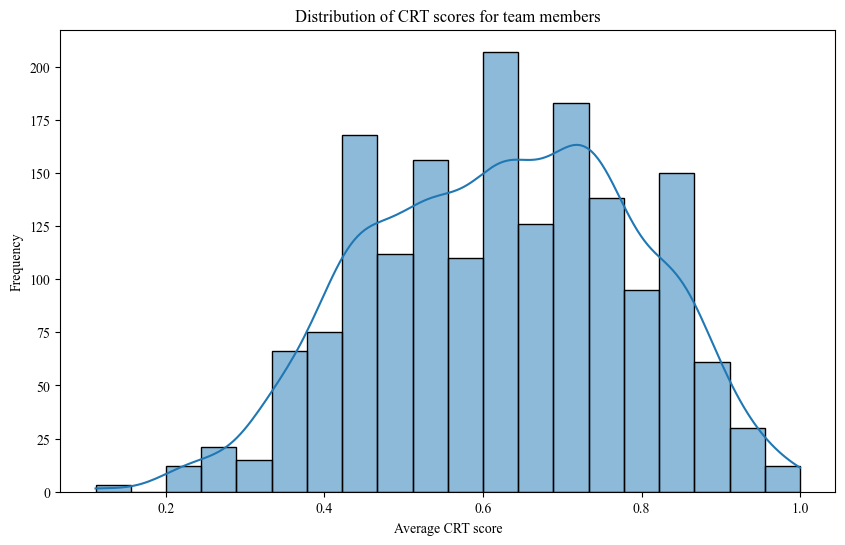

In [55]:
# plot the CRT histogram distribution of team_composition_by_stageId["CRT"]
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["CRT"], bins=20, kde=True)
plt.title("Distribution of CRT scores for team members")
plt.xlabel("Average CRT score")
plt.ylabel("Frequency")
plt.show()

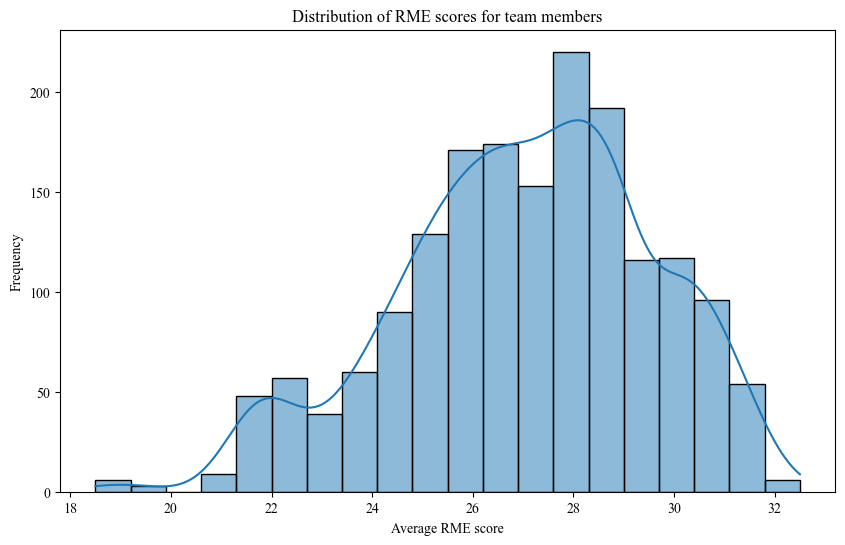

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["RME"], bins=20, kde=True)
plt.title("Distribution of RME scores for team members")
plt.xlabel("Average RME score")
plt.ylabel("Frequency")
plt.show()

In [57]:
# add in RME and CRT to the team multi-task data
team_multi_task_data = team_multi_task_data.merge(team_composition_by_stageId, on = "stageId", how = "inner")

# Exploratory Correlations within Task Map

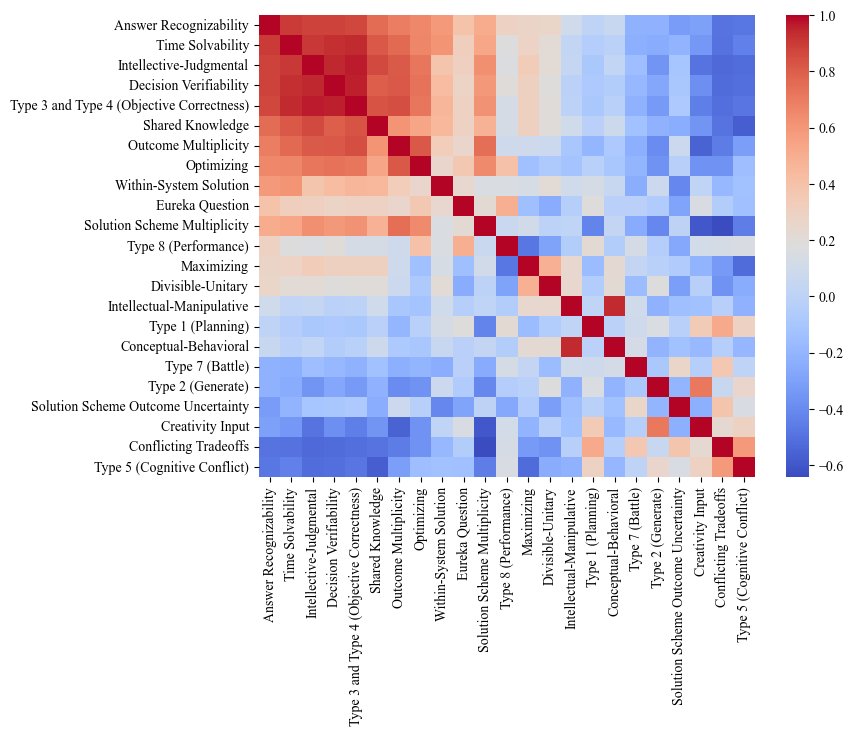

In [58]:
# do a correlation plot for task_map
task_map_without_name = task_map.drop(columns=['task_name', 'Type 6 (Mixed-Motive)'])
correlation_matrix = task_map_without_name.corr()
average_correlation = correlation_matrix.mean()
sorted_columns = average_correlation.sort_values(ascending=False).index
sorted_correlation_matrix = correlation_matrix.reindex(index=sorted_columns, columns=sorted_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(sorted_correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.show()

In [59]:
# average groups of columns in task_map that have high correlation

# Find pairs of columns with correlation greater than 0.5
corr_pairs = correlation_matrix.abs().unstack()
high_corr_pairs = corr_pairs[corr_pairs > 0.6]
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1].drop_duplicates().index

# Function to find groups of columns with high correlations
def find_groups(pairs):
    groups = []
    for pair in pairs:
        added = False
        for group in groups:
            if pair[0] in group or pair[1] in group:
                group.update(pair)
                added = True
                break
        if not added:
            groups.append(set(pair))
    return groups

# Find groups of columns to average
groups = find_groups(high_corr_pairs)

In [60]:
groups

[{'Conceptual-Behavioral', 'Intellectual-Manipulative'},
 {'Creativity Input', 'Solution Scheme Multiplicity', 'Type 2 (Generate)'},
 {'Answer Recognizability',
  'Conflicting Tradeoffs',
  'Decision Verifiability',
  'Intellective-Judgmental',
  'Optimizing',
  'Outcome Multiplicity',
  'Shared Knowledge',
  'Solution Scheme Multiplicity',
  'Time Solvability',
  'Type 3 and Type 4 (Objective Correctness)',
  'Within-System Solution'}]

In [61]:
# Average the columns within each group and add to a new DataFrame
averaged_columns = {}
for i, group in enumerate(groups):
    columns = list(group)
    averaged_columns[f'group_{i+1}'] = task_map[columns].mean(axis=1)

new_averaged_cols = pd.DataFrame(averaged_columns).rename(columns={"group_1": "Physical-Mental", "group_2": "Creativity", "group_3": "Demonstrability"})

In [62]:
# flatten the groups object
flattened_groups = list(itertools.chain(*groups))

In [63]:
task_map_combined = pd.concat([task_map.drop(flattened_groups, axis = 1), new_averaged_cols], axis = 1)

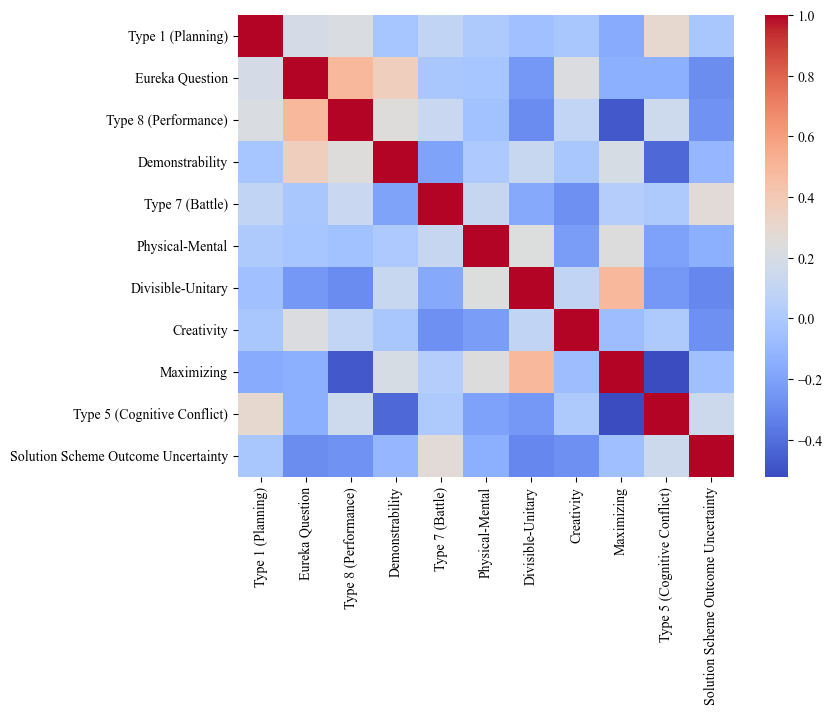

In [64]:
# new correlation plot after combining
task_map_without_name = task_map_combined.drop(columns=['task_name', 'Type 6 (Mixed-Motive)'])
correlation_matrix = task_map_without_name.corr()
average_correlation = correlation_matrix.mean()
sorted_columns = average_correlation.sort_values(ascending=False).index
sorted_correlation_matrix = correlation_matrix.reindex(index=sorted_columns, columns=sorted_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(sorted_correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.show()

## Concatenate the Task Map to the Data

In [65]:
# CHOICES: LASSO, COMBINED, STANDARD, INDEPENDENT, BEST_6
FEATURE_CHOICE = 'BEST_6'

assert(FEATURE_CHOICE in {"LASSO", "COMBINED", "STANDARD", "INDEPENDENT", "BEST_6"})

In [66]:
# merge in the task features
if FEATURE_CHOICE == 'COMBINED':
    task_map_to_merge = task_map_combined
else: 
    task_map_to_merge = task_map

full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map_to_merge, on = "task_name", how = "left")
team_multi_task_data = pd.merge(left = team_multi_task_data, right = task_map_to_merge, on = "task_name", how = "left")

# create dummies for complexity (commented out because this is already done in the latest data dump)
# complexity_columns = ["High", "Low", "Medium"]
# full_multi_task_data = pd.get_dummies(full_multi_task_data, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
# full_multi_task_data[complexity_columns] = full_multi_task_data[complexity_columns].astype(int)

In [67]:
# this is our new task_cols_to_use
task_cols_to_use = task_map_to_merge.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

# Exploratory linear regressions

Three outcome variables:
1. **Score**: Normalized such that the highest scoring team gets 100
2. **Duration**: Amount of time spent completing the task (in minutes)
3. **Efficiency**: Score / Duration

In [68]:
def feature_downselect_with_lasso(cols, data = team_multi_task_data):
    lassocv = LassoCV(cv=10, random_state=0, max_iter=100000).fit(data[cols], data["score"])
    best_alpha = lassocv.alpha_
    fitted_lasso_model = Lasso(alpha = best_alpha, max_iter=100000).fit(data[cols], data["score"])

    lasso_feature_names = fitted_lasso_model.feature_names_in_
    lasso_coefs = fitted_lasso_model.coef_

    lasso_weights = pd.DataFrame(
        {"features": lasso_feature_names,
        "LASSO_weight": lasso_coefs}
    )

    # filter for LASSO_weight != 0
    return lasso_weights[lasso_weights['LASSO_weight'] != 0]["features"]

In [69]:
if FEATURE_CHOICE == 'LASSO':
    nonzero_lasso_weights_task = feature_downselect_with_lasso(list(task_cols_to_use))
    task_features = nonzero_lasso_weights_task # this is from LASSO
elif FEATURE_CHOICE == 'STANDARD' or FEATURE_CHOICE == 'COMBINED':
    task_features = task_cols_to_use # this is all the task features in the task map
elif FEATURE_CHOICE == "BEST_6": # this is from our comprehensive analysis of the best ways to select 6 columns
    q2_from_diff_task_cols = pd.read_csv("./task_map_explorations_with_multitask/q2_OLS_from_diff_task_cols.csv")
    maxq2_cols = q2_from_diff_task_cols.iloc[q2_from_diff_task_cols["q2"].idxmax()]
    task_features = list(ast.literal_eval(maxq2_cols["selected_task_cols"]))
elif FEATURE_CHOICE == 'INDEPENDENT':
    task_features = full_rank_cols_for_selected_tasks # this was from the QR decomposition

In [70]:
# Set coefficients to use
"""
We want:
- Task Features
- Team Size
- CRT and RME Score

Version 1: Let's Intersect them all against each other
"""
for task_col in task_features:
    # intersect with team size
    task_col_x_teamsize = team_multi_task_data[task_col]*team_multi_task_data["playerCount"]
    team_multi_task_data.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

    # intersect with CRT
    task_col_x_CRT = team_multi_task_data[task_col]*team_multi_task_data["CRT"]
    team_multi_task_data.loc[:, task_col + " x CRT"] = task_col_x_CRT

    # intersect with RME
    task_col_x_RME = team_multi_task_data[task_col]*team_multi_task_data["RME"]
    team_multi_task_data.loc[:, task_col + " x RME"] = task_col_x_RME

In [71]:
task_cols_and_derivatives = list(task_features) + [col for col in team_multi_task_data.columns if "x" in col]
# get a unique list
task_cols_and_derivatives = list(set(task_cols_and_derivatives))

In [72]:
all_features_and_interactions = task_cols_and_derivatives + ["CRT", "RME", "playerCount"] + ["High", "Medium"]

In [73]:
RME_and_interactions = [col for col in all_features_and_interactions if "RME" in col]
CRT_and_interactions = [col for col in all_features_and_interactions if "CRT" in col]
playerCount_and_interactions = [col for col in all_features_and_interactions if "playerCount" in col]

In [74]:
# RME_and_interactions = list(feature_downselect_with_lasso(RME_and_interactions))
# CRT_and_interactions = list(feature_downselect_with_lasso(CRT_and_interactions))
# playerCount_and_interactions = list(feature_downselect_with_lasso(playerCount_and_interactions))

In [75]:
controls = ["High", "Medium"]

In [76]:
# Design decision --- standardize iv (standardize task features, RME, CRT, and any interaction terms involving task features)
team_multi_task_data = team_multi_task_data.copy()
team_multi_task_data[all_features_and_interactions] = StandardScaler().fit_transform(team_multi_task_data[all_features_and_interactions])

In [77]:
team_multi_task_data[task_cols_and_derivatives].describe()

,Type 6 (Mixed-Motive),Creativity Input x CRT,Creativity Input,Shared Knowledge,Type 3 and Type 4 (Objective Correctness) x RME,Shared Knowledge x playerCount,Type 8 (Performance) x playerCount,Type 3 and Type 4 (Objective Correctness) x playerCount,Type 7 (Battle) x playerCount,Type 8 (Performance) x CRT,...,Type 8 (Performance) x RME,Solution Scheme Multiplicity x RME,Creativity Input x RME,Solution Scheme Multiplicity,Shared Knowledge x CRT,Type 7 (Battle),Type 3 and Type 4 (Objective Correctness) x CRT,Type 3 and Type 4 (Objective Correctness),Type 8 (Performance),Type 7 (Battle) x RME
count,1740.0,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,...,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03,1.740000e+03
mean,0.0,3.695639e-16,-2.878923e-16,1.102566e-16,2.756416e-17,-2.307222e-16,7.350442e-17,3.021848e-16,-1.245492e-16,-2.245968e-17,...,4.083579e-17,8.779695e-17,2.041789e-17,-1.225074e-16,-4.083579e-18,-1.225074e-17,6.125368e-18,2.674744e-16,-6.125368e-18,1.572178e-16
std,0.0,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,...,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00,1.000287e+00
min,0.0,-1.497981e+00,-1.492912e+00,-1.599844e+00,-1.543208e+00,-1.343339e+00,-6.422632e-01,-1.321490e+00,-1.707743e+00,-6.946376e-01,...,-6.809542e-01,-1.395378e+00,-1.536765e+00,-1.414671e+00,-1.414174e+00,-2.218656e+00,-1.409162e+00,-1.553130e+00,-6.620199e-01,-2.182997e+00
25%,0.0,-8.161980e-01,-7.366301e-01,-9.791051e-01,-8.186735e-01,-9.850599e-01,-5.620389e-01,-8.888254e-01,-4.867214e-01,-5.860490e-01,...,-6.294539e-01,-1.028365e+00,-7.667575e-01,-1.043562e+00,-9.205228e-01,-2.056624e-01,-8.436238e-01,-7.969930e-01,-6.445784e-01,-2.717703e-01
50%,0.0,-2.010880e-01,-3.761359e-01,6.632661e-01,2.041036e-01,2.508929e-02,-4.489956e-01,-4.878213e-02,-2.425172e-01,-4.438840e-01,...,-4.668307e-01,1.033497e-01,-1.302793e-01,3.249040e-01,6.125496e-02,2.975860e-01,-1.623673e-01,6.710915e-01,-3.902241e-01,2.175220e-01
75%,0.0,7.215769e-01,8.520865e-01,8.690033e-01,9.500446e-01,8.280516e-01,-8.069324e-02,1.619311e-01,7.342998e-01,-1.874769e-01,...,-2.632452e-01,7.500476e-01,8.166483e-01,6.939048e-01,8.244076e-01,5.492103e-01,8.690394e-01,1.039340e+00,-2.783082e-01,6.149285e-01
max,0.0,2.965782e+00,1.523391e+00,9.865675e-01,1.553619e+00,1.642323e+00,3.106399e+00,1.707161e+00,2.043235e+00,3.602370e+00,...,2.732860e+00,2.007622e+00,2.041224e+00,1.537335e+00,2.082453e+00,1.324213e+00,2.161041e+00,1.039340e+00,2.262329e+00,1.870763e+00


In [78]:
task_features =  list(task_features)
task_features

['Type 7 (Battle)',
 'Type 8 (Performance)',
 'Solution Scheme Multiplicity',
 'Shared Knowledge',
 'Type 3 and Type 4 (Objective Correctness)',
 'Creativity Input']

In [79]:
# this is the feature R says we should drop.
# task_features.remove("Outcome Multiplicity")

In [80]:
# lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features])).fit() #+ ["CRT", "RME", "playerCount", "High", "Medium"]])).fit()
# Stargazer([lm])

In [81]:
# exporting to work in R
# team_multi_task_data[list(task_cols_to_use) + ["score"]].to_csv("task_map_explorations_with_multitask/team_multi_task_with_task_features.csv", index = False)

In [82]:
# reduce with LASSO
# lasso_features = feature_downselect_with_lasso(cols = list(task_cols_to_use) + ["CRT", "RME", "playerCount", "High", "Medium"], data = team_multi_task_data[list(task_cols_to_use) + ["CRT", "RME", "playerCount", "High", "Medium", "score"]])
# df = team_multi_task_data[list(lasso_features) + ["score"]]
# x = list(df.columns.difference(["score"]))
# lm = sm.OLS(endog = df["score"], exog=sm.add_constant(df[x])).fit()
# Stargazer([lm])

In [83]:
# reduce with QR decomposition
# df = reduce_to_full_rank(team_multi_task_data[list(task_cols_to_use) + ["CRT", "RME", "playerCount", "High", "Medium", "score"]])
# x = list(df.columns.difference(["score"]))
# lm = sm.OLS(endog = df["score"], exog=sm.add_constant(df[x])).fit()
# Stargazer([lm])

In [84]:
# test_singularity(team_multi_task_data[task_features + ["CRT", "RME", "playerCount", "High", "Medium"]].drop_duplicates())

In [85]:
# team_plus_controls = team_multi_task_data[task_features + ["CRT", "RME", "playerCount", "High", "Medium", "score"]]

In [86]:
# team_plus_controls.to_csv("task_map_explorations_with_multitask/team_multi_task_data_with_controls.csv", index = False)

In [87]:
task_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features + controls])).fit()

In [88]:
giant_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features + CRT_and_interactions + RME_and_interactions + playerCount_and_interactions + controls])).fit()

In [89]:
task_crt_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features + CRT_and_interactions + controls])).fit()
task_rme_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features + RME_and_interactions + controls])).fit()
task_playercount_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[task_features + playerCount_and_interactions + controls])).fit()

models = [task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm]
stargazer = Stargazer(models)

In [90]:
stargazer

## LRT of interaction on top of main effect

In [91]:
lr_statistic, p_value, df = task_crt_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
46.03036962598344
p-value
8.623818418804662e-08


In [92]:
lr_statistic, p_value, df = task_rme_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
17.580872591617663
p-value
0.014011142232246114


In [93]:
lr_statistic, p_value, df = task_playercount_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
113.11346658226103
p-value
2.0731660936985976e-21


## Correct all p-values and Standard Errors for Multiple Comparisons

In [94]:
p_values = [task_lm.pvalues, task_crt_lm.pvalues, task_rme_lm.pvalues, task_playercount_lm.pvalues, giant_lm.pvalues]

# Flatten the list of p-values
all_p_values = [p for sublist in p_values for p in sublist]

# Apply Benjamini-Hochberg correction
rejected, corrected_p_values, _, _ = multitest.multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# Map the corrected p-values back to the original p-values structure
len_task = len(task_lm.pvalues)
len_task_crt = len(task_crt_lm.pvalues)
len_task_rme = len(task_rme_lm.pvalues)
len_task_playercount = len(task_playercount_lm.pvalues)

corrected_p_values_task = pd.Series(corrected_p_values[:len_task], index=task_lm.pvalues.index)
corrected_p_values_task_crt = pd.Series(corrected_p_values[len_task:len_task+len_task_crt], index=task_crt_lm.pvalues.index)
corrected_p_values_task_rme = pd.Series(corrected_p_values[len_task+len_task_crt:len_task+len_task_crt+len_task_rme], index=task_rme_lm.pvalues.index)
corrected_p_values_task_playercount = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme:len_task+len_task_crt+len_task_rme+len_task_playercount], index=task_playercount_lm.pvalues.index)
corrected_p_values_giant = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme+len_task_playercount:], index=giant_lm.pvalues.index)

# Corrected p-values
task_lm.pvalues_corrected = corrected_p_values_task
task_crt_lm.pvalues_corrected = corrected_p_values_task_crt
task_rme_lm.pvalues_corrected = corrected_p_values_task_rme
task_playercount_lm.pvalues_corrected = corrected_p_values_task_playercount
giant_lm.pvalues_corrected = corrected_p_values_giant

# Corrected standard errors
corrected_t_values_task = stats.norm.ppf(1 - corrected_p_values_task / 2) * np.sign(task_lm.tvalues)
corrected_t_values_task_crt = stats.norm.ppf(1 - corrected_p_values_task_crt / 2) * np.sign(task_crt_lm.tvalues)
corrected_t_values_task_rme = stats.norm.ppf(1 - corrected_p_values_task_rme / 2) * np.sign(task_rme_lm.tvalues)
corrected_t_values_task_playercount = stats.norm.ppf(1 - corrected_p_values_task_playercount / 2) * np.sign(task_playercount_lm.tvalues)
corrected_t_values_giant = stats.norm.ppf(1 - corrected_p_values_giant / 2) * np.sign(giant_lm.tvalues)

corrected_se_task = task_lm.params / corrected_t_values_task
corrected_se_task_crt = task_crt_lm.params / corrected_t_values_task_crt
corrected_se_task_rme = task_rme_lm.params / corrected_t_values_task_rme
corrected_se_task_playercount = task_playercount_lm.params / corrected_t_values_task_playercount
corrected_se_giant = giant_lm.params / corrected_t_values_giant

task_lm.bse_corrected = corrected_se_task
task_crt_lm.bse_corrected = corrected_se_task_crt
task_rme_lm.bse_corrected = corrected_se_task_rme
task_playercount_lm.bse_corrected = corrected_se_task_playercount
giant_lm.bse_corrected = corrected_se_giant

## Separating Task Effects

In [95]:
def intensify_color(color, factor=0.5):
    """ Make the color more intense by scaling the RGB values. """
    color_rgb = mcolors.to_rgb(color)
    return tuple(min(1, c * factor) for c in color_rgb)

In [96]:
def plot_models(models, features_to_plot, model_names, colors, title, figsize = (8, 10), pval_thresh = 0.05, y_jitter = 1.3):
    # Create a DataFrame to organize the parameters for easier manipulation
    pvalues_corrected_df = pd.DataFrame([model.pvalues_corrected for model in models], index=model_names).filter(features_to_plot)
    params_df = pd.DataFrame([model.params for model in models], index=model_names).filter(features_to_plot)

    sorted_columns = params_df.sum().sort_values(ascending=False).index

    # order everything by smallest to largest effect size
    params_df = params_df.reindex(columns=sorted_columns)
    pvalues_corrected_df = pvalues_corrected_df.reindex(columns=sorted_columns)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)
    stderr_corrected_df = pd.DataFrame([model.bse_corrected for model in models], index=model_names).reindex(columns=sorted_columns)

    fig, ax = plt.subplots(figsize=figsize)
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    #### THIS PLOTS THE REGULAR THING ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        plot_color = colors[i]

        # Plot corrected errors with colored solid lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors_corrected, fmt='o', color=plot_color, capsize=3, label=f'{model_name}')# (SE Corrected)')

        # Plot uncorrected errors with gray broken lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)# label=f'{model_name} (SE Uncorrected)')

    ### THIS GRAYS OUT THE NON-SIGNIFICANT ONES ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        # Iterate over each point and plot it with its corresponding color based on p-value significance
        for j, (mean, error, error_corrected, pval) in enumerate(zip(means, errors, errors_corrected, pvalues_corrected)):
            plot_color = colors[i] if pval <= pval_thresh else 'lightgray'
            # Plot corrected errors with colored solid lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error_corrected, fmt='o', color=plot_color, capsize=3)
            # Plot uncorrected errors with gray broken lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)
       
    ax.set_title(title)
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * y_jitter / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7) 
    if(len(models) > 1): 
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

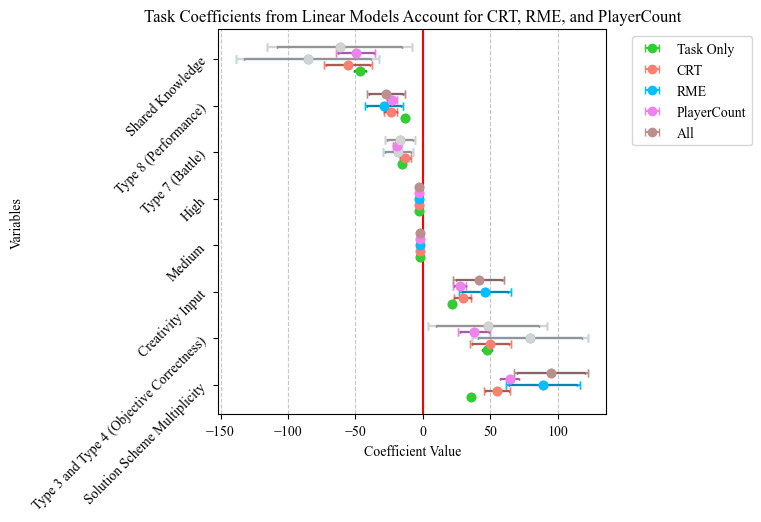

In [97]:
plot_models(models, features_to_plot=list(task_cols_to_use) + controls, model_names=["Task Only", "CRT", "RME", "PlayerCount", "All"], colors=['limegreen', 'salmon', 'deepskyblue', 'violet', 'rosybrown'], title='Task Coefficients from Linear Models Account for CRT, RME, and PlayerCount', figsize = (5, 5))

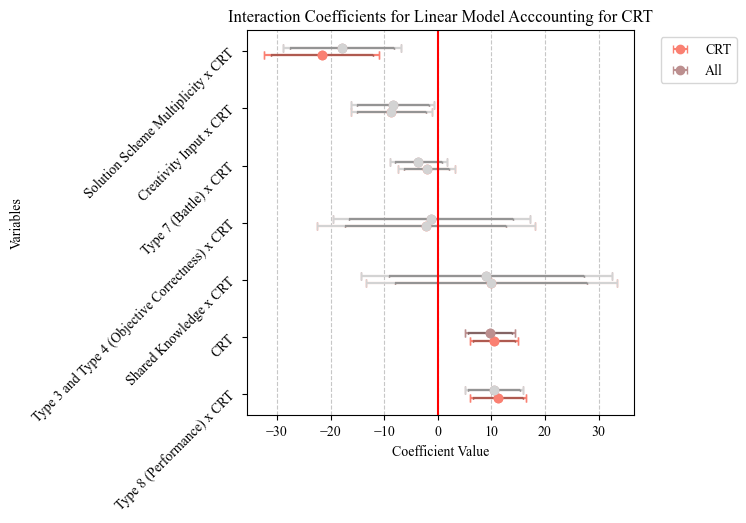

In [98]:
plot_models([task_crt_lm, giant_lm], features_to_plot=CRT_and_interactions, model_names=["CRT", "All"], colors=['salmon', 'rosybrown'], title='Interaction Coefficients for Linear Model Acccounting for CRT', figsize = (5, 5))

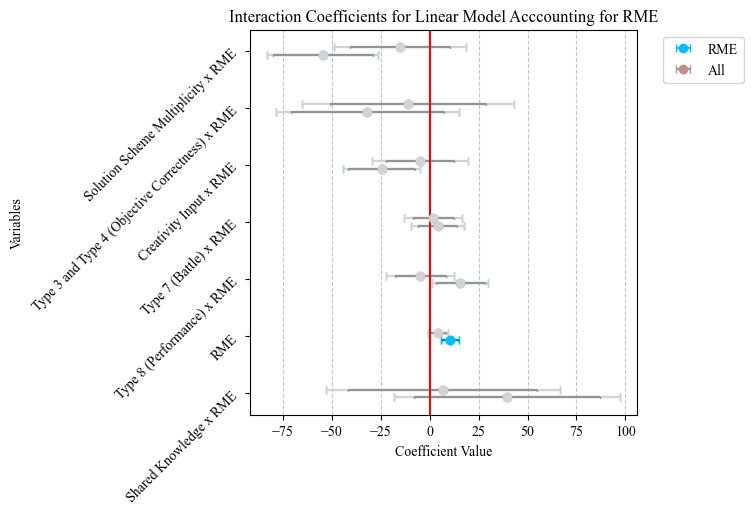

In [99]:
plot_models([task_rme_lm, giant_lm], features_to_plot=RME_and_interactions, model_names=["RME", "All"], colors=['deepskyblue', 'rosybrown'], title='Interaction Coefficients for Linear Model Acccounting for RME', figsize = (5, 5))

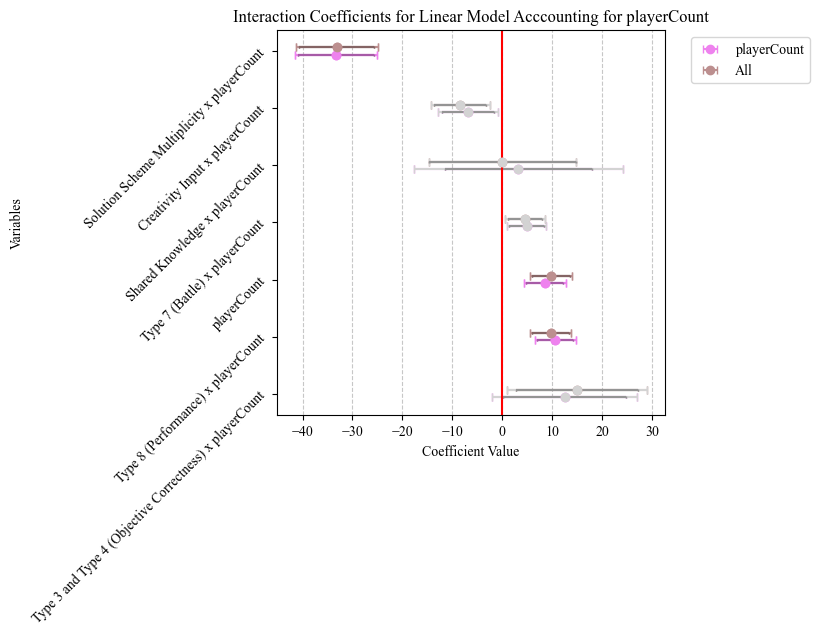

In [100]:
plot_models([task_playercount_lm, giant_lm], features_to_plot=playerCount_and_interactions, model_names=["playerCount", "All"], colors=['violet', 'rosybrown'], title='Interaction Coefficients for Linear Model Acccounting for playerCount', figsize = (5, 5))

# Adding back Communication Features

Commenting out communication features because we don't have comms data for waves 2 and 3 yet!

In [101]:
full_multi_task_messages = pd.read_csv('./task_map_explorations_with_multitask/multi_task_chat.csv')
full_multi_task_messages = full_multi_task_messages.rename(columns={
    "stageId": "conversation_num",
    "playerId": "speaker_nickname",
    "time": "timestamp"
})

In [102]:
sys.path.insert(0, './features/team-process-map/feature_engine')

In [103]:
from feature_builder import FeatureBuilder as FeatureBuilder

[nltk_data] Downloading package stopwords to /Users/xehu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/xehu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [104]:
len(full_multi_task_messages)


14339

In [105]:
# feature_builder = FeatureBuilder(
#     input_df = full_multi_task_messages,
#     vector_directory = "./task_map_explorations_with_multitask/message_vectors/",
#     output_file_path_chat_level = "./task_map_explorations_with_multitask/tpm_outputs/chat/full_multi_task_messages_chat_level.csv",
#     output_file_path_user_level = "./task_map_explorations_with_multitask/tpm_outputs/user/full_multi_task_messages_user_level.csv",
#     output_file_path_conv_level = "./task_map_explorations_with_multitask/tpm_outputs/conv/full_multi_task_messages_conversation_level.csv",
#     turns = False,
# )
# feature_builder.featurize(col="message")

In [106]:
full_conversation_data = pd.read_csv("./task_map_explorations_with_multitask/tpm_outputs/conv/full_multi_task_messages_conversation_level.csv")
full_conversation_data = full_conversation_data.rename(columns={"conversation_num": "stageId"})
full_conversation_data.columns
full_conversation_data = full_conversation_data.drop(columns = ['speaker_nickname', 'message',
       'timestamp', 'message_original', 'message_lower_with_punc'], axis = 1)

Explore a few candidate communication DV's

In [107]:
team_multi_task_data_conv = pd.merge(full_conversation_data, team_multi_task_data, on = "stageId", how = "inner")

# this is a bit arbitrary, but here are a few columns that we can select for the conversation level
COMMS_DVS = ["turn_taking_index", "gini_coefficient_sum_num_messages", "sum_num_messages", "average_positive_bert", "team_burstiness"]

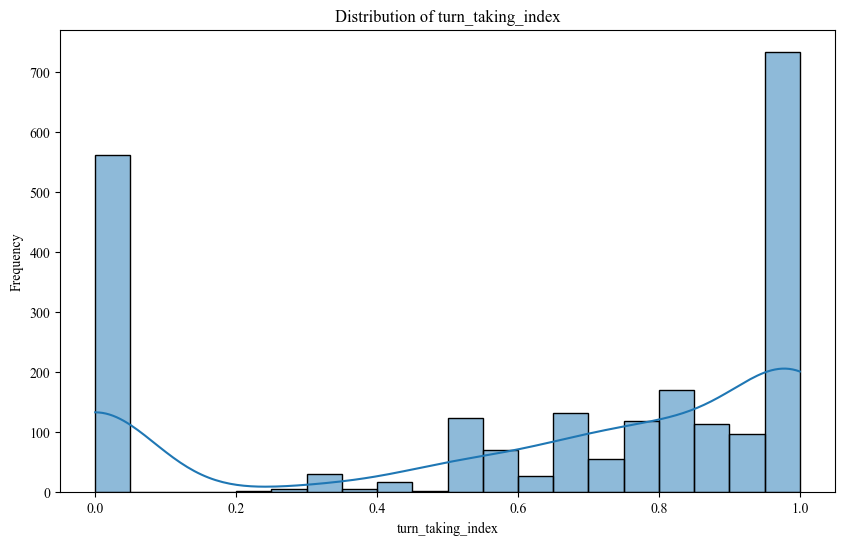

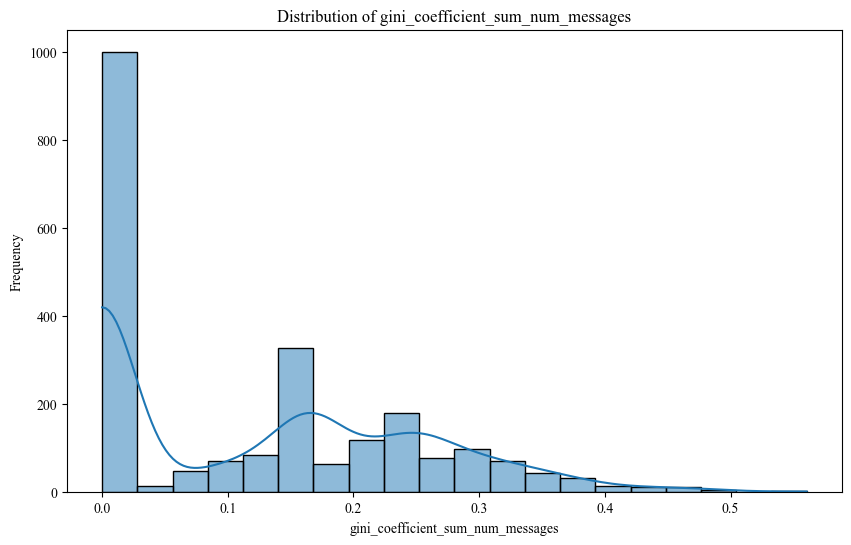

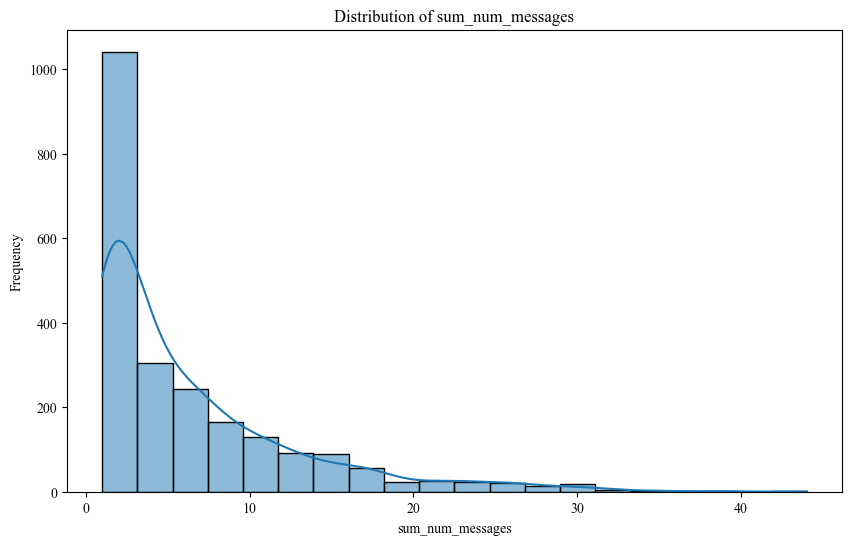

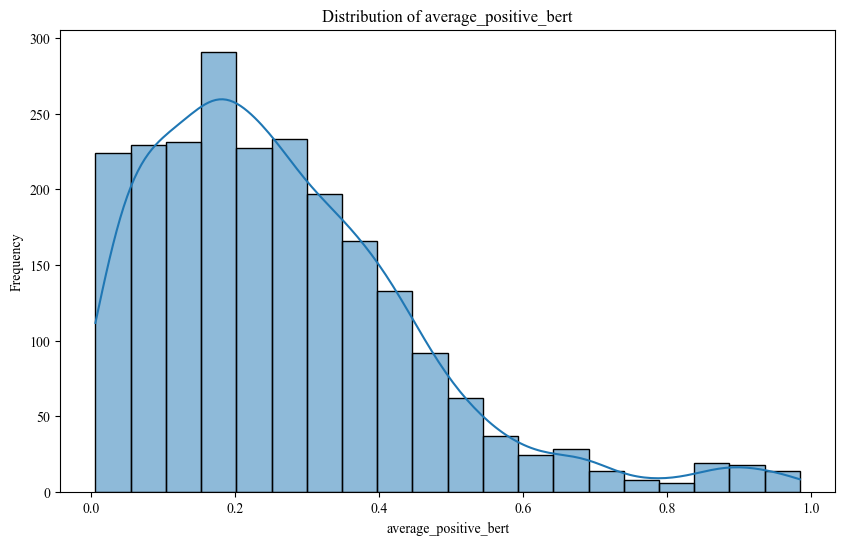

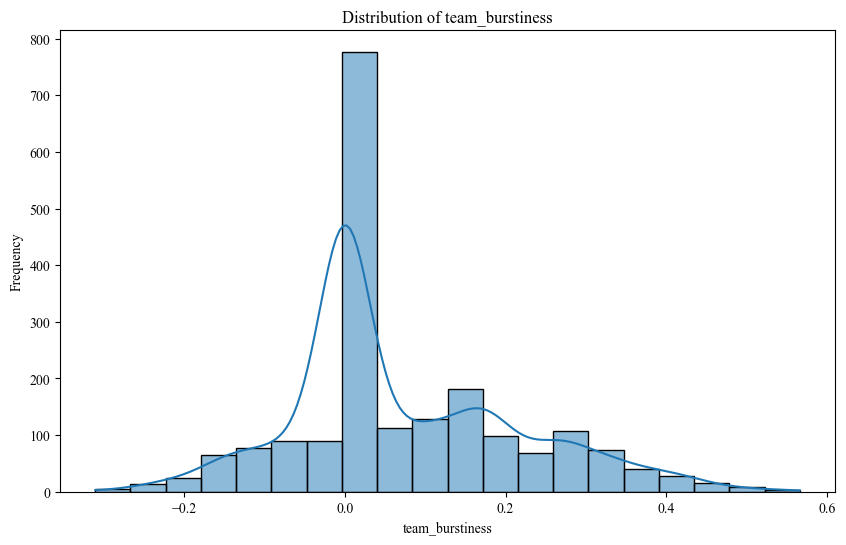

In [108]:
def plot_exploratory_distribution(col):
    plt.figure(figsize=(10, 6))
    sns.histplot(full_conversation_data[col], bins=20, kde=True)
    plt.title("Distribution of " + col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

for col in COMMS_DVS:
    plot_exploratory_distribution(col)

In [109]:
# z-score our communication features to put them on the same scale
team_multi_task_data_conv[COMMS_DVS] = StandardScaler().fit_transform(team_multi_task_data_conv[COMMS_DVS])
# drop rows in which the dv's are NA
team_multi_task_data_conv = team_multi_task_data_conv.dropna(subset = COMMS_DVS).reset_index(drop=True)

Plot some linear regressions for our 5 communication dependent variables

In [110]:
csvs = []

for dv in COMMS_DVS:
    csv_name = "./task_map_explorations_with_multitask/" + dv + "_" + "q2_OLS_from_diff_task_cols.csv"
    csv = pd.read_csv(csv_name).rename(columns = {"q2": "q2_" + dv})
    csvs.append(csv)

comms_csvs = pd.merge(csvs[0], csvs[1], on = "selected_task_cols", how = "inner")

for csv in csvs[2:]:
    comms_csvs = pd.merge(comms_csvs, csv, on = "selected_task_cols", how = "inner")

In [111]:
# get the best set of cols for each one
best_cols = {}

for dv in COMMS_DVS:
    col = "q2_" + dv
    maxq2_cols = comms_csvs.iloc[comms_csvs[col].idxmax()]
    best_cols[dv] = ast.literal_eval(maxq2_cols["selected_task_cols"])

In [112]:
# get the union of all the best columns
best_colset = [colset for colset in best_cols.values()]
best_colset = list(set([col for sublist in best_colset for col in sublist]))

In [113]:
for task_col in best_colset:
    # intersect with team size
    task_col_x_teamsize = team_multi_task_data_conv[task_col]*team_multi_task_data_conv["playerCount"]
    team_multi_task_data_conv.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

    # intersect with CRT
    task_col_x_CRT = team_multi_task_data_conv[task_col]*team_multi_task_data_conv["CRT"]
    team_multi_task_data_conv.loc[:, task_col + " x CRT"] = task_col_x_CRT

    # intersect with RME
    task_col_x_RME = team_multi_task_data_conv[task_col]*team_multi_task_data_conv["RME"]
    team_multi_task_data_conv.loc[:, task_col + " x RME"] = task_col_x_RME

In [114]:
col_list_for_comms_dv = {}
for dv in COMMS_DVS:
    col_list = []
    for task_col in best_cols[dv]:
        col_list = col_list + [col for col in team_multi_task_data_conv.columns if task_col in col]
    col_list_for_comms_dv[dv] = col_list

In [115]:
turn_taking_lm = sm.OLS(endog = team_multi_task_data_conv["turn_taking_index"], exog=sm.add_constant(team_multi_task_data_conv[col_list_for_comms_dv["turn_taking_index"]])).fit()
burstiness_lm = sm.OLS(endog = team_multi_task_data_conv["team_burstiness"], exog=sm.add_constant(team_multi_task_data_conv[col_list_for_comms_dv["team_burstiness"]])).fit()

gini_lm = sm.OLS(endog = team_multi_task_data_conv["gini_coefficient_sum_num_messages"], exog=sm.add_constant(team_multi_task_data_conv[col_list_for_comms_dv["gini_coefficient_sum_num_messages"]])).fit()
total_messages_lm = sm.OLS(endog = team_multi_task_data_conv["sum_num_messages"], exog=sm.add_constant(team_multi_task_data_conv[col_list_for_comms_dv["sum_num_messages"]])).fit()
positivity_lm = sm.OLS(endog = team_multi_task_data_conv["average_positive_bert"], exog=sm.add_constant(team_multi_task_data_conv[col_list_for_comms_dv["average_positive_bert"]])).fit()

conv_models = [turn_taking_lm, gini_lm, total_messages_lm, positivity_lm, burstiness_lm]
stargazer = Stargazer(conv_models)

In [116]:
stargazer

## Recreation of PCA Plot (Figure 4) with Real Data

In [117]:
numeric_columns = [col for col in team_multi_task_data.columns if (team_multi_task_data[col].dtype == "int64" or team_multi_task_data[col].dtype == "float64")]

In [118]:
grouped_avg_all_tasks = team_multi_task_data.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [119]:
pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(grouped_avg_all_tasks[task_cols_to_use])
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

# add dvs
pca_df["score"] = grouped_avg_all_tasks["score"]
pca_df["duration"] = grouped_avg_all_tasks["duration"]
pca_df["efficiency"] = grouped_avg_all_tasks["efficiency"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

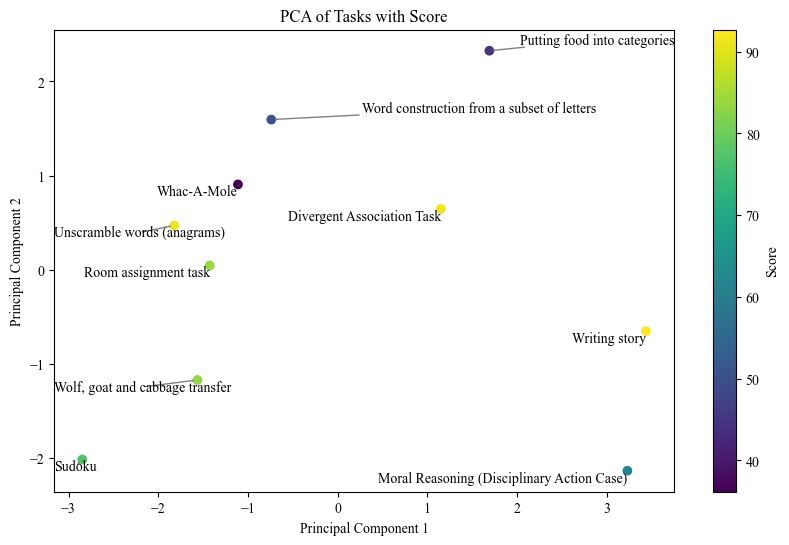

In [120]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    # plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "score", dv_label="Score")

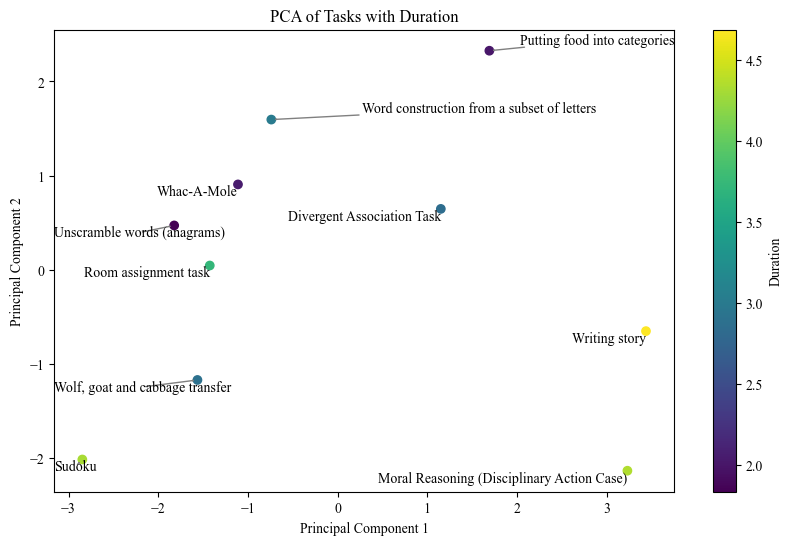

In [121]:
plot_pca_scatter_with_labels(pca_df, dv = "duration", dv_label="Duration")

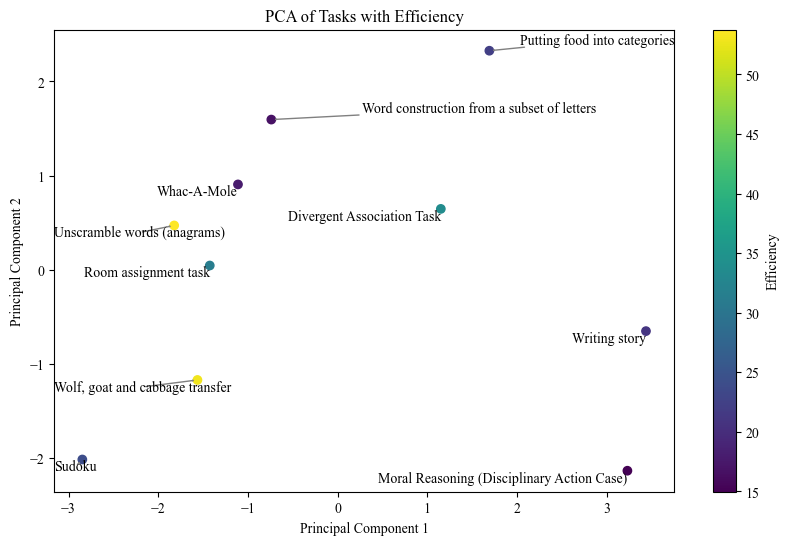

In [122]:
plot_pca_scatter_with_labels(pca_df, dv = "efficiency", dv_label="Efficiency")

# Q^2 Calculation

In [123]:
def reshape_x_y(x, y):
    if(isinstance(x, pd.Series)):
        x = np.asarray(x).reshape(-1, 1)
    else:
        x = np.asarray(x)
    
    y = np.asarray(y).reshape(-1, 1)
    return(x, y)

In [124]:
def q2_task_holdout_helper(x_train, x_test, y_train, y_test, estimator):
    
    # some reshaping
    x_train_array, y_train_array = reshape_x_y(x_train, y_train)
    x_test_array, y_test_array = reshape_x_y(x_test, y_test)

    # print("Training data: ", pd.DataFrame(x_train_array).head())
    # print("Testing data: ", pd.DataFrame(x_test_array).head())

    # Fit the model and get the error
    fitted_model = estimator.fit(X=x_train_array, y=y_train_array.ravel())
    
    # save prediction error
    prediction = fitted_model.predict(x_test_array)

    # flatten all arrays
    y_test_array = np.asarray(y_test_array).flatten()
    prediction = np.asarray(prediction).flatten()

    # print("y test array", y_test_array)
    # print("prediction", prediction)

    squared_model_prediction_error = (y_test_array - prediction) ** 2

    # save total error for this fold
    squared_average_prediction_error = (y_test_array - np.mean(y_train_array)) ** 2

    return squared_model_prediction_error, squared_average_prediction_error

In [125]:
"""
This is the version of q^2 that holds out EVERYTHING associated with a given task

It trains on all task instances from the "seen" classes, and it tests on task instances of held-out (unseen) classes.

NOTE: this version of the function assumes that x and y are passed in with a column called "task_name"
"""

def get_q2(y, x, estimator = Lasso(), num_task_holdouts = 1):

    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    num_total_tasks = x["task_name"].nunique()

    # randomly hold out `num_task_holdouts`
    all_possible_task_combos = list(itertools.combinations((x["task_name"].unique()), num_total_tasks - num_task_holdouts))
    
    for sample in all_possible_task_combos:

        # print("Sample:", sample)
        # print("Held out:", x[~x["task_name"].isin(sample)]["task_name"].unique())

        x_train_tasks = x[x["task_name"].isin(sample)].drop("task_name", axis = 1)
        x_test_tasks = x[~x["task_name"].isin(sample)].drop("task_name", axis = 1)

        y_train_tasks = y[y["task_name"].isin(sample)].drop("task_name", axis = 1)
        y_test_tasks = y[~y["task_name"].isin(sample)].drop("task_name", axis = 1)

        # get evaluation score by training on the training tasks and evaluating on the holdout tasks
        squared_model_prediction_error, squared_average_prediction_error = q2_task_holdout_helper(x_train_tasks, x_test_tasks, y_train_tasks, y_test_tasks, estimator)
        
        squared_model_prediction_errors.append(squared_model_prediction_error)
        squared_average_prediction_errors.append(squared_average_prediction_error)

    # Print the evaluation score
    squared_model_prediction_error = np.asarray(squared_model_prediction_error).flatten()
    squared_average_prediction_error = np.asarray(squared_average_prediction_error).flatten()

    # print(squared_model_prediction_error)
    # print(squared_average_prediction_error)
    return 1 - (np.sum(squared_model_prediction_error) / np.sum(squared_average_prediction_error))


In [126]:
# set up prediction
y_score = team_multi_task_data[["score", "task_name"]]
y_duration = team_multi_task_data[["duration", "task_name"]]
y_efficiency = team_multi_task_data[["efficiency", "task_name"]]

x_tasks = team_multi_task_data[list(all_features_and_interactions) + ["task_name"]]

In [127]:
x_tasks_maintaskonly = team_multi_task_data[list(task_cols_to_use) + ["High", "Medium", "task_name"]]
x_tasks_maintaskonly.columns

Index(['Conceptual-Behavioral', 'Type 1 (Planning)', 'Type 2 (Generate)',
       'Type 5 (Cognitive Conflict)', 'Type 7 (Battle)',
       'Type 8 (Performance)', 'Divisible-Unitary', 'Maximizing', 'Optimizing',
       'Outcome Multiplicity', 'Solution Scheme Multiplicity',
       'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution',
       'Answer Recognizability', 'Time Solvability',
       'Type 3 and Type 4 (Objective Correctness)', 'Conflicting Tradeoffs',
       'Solution Scheme Outcome Uncertainty', 'Eureka Question',
       'Intellectual-Manipulative', 'Intellective-Judgmental',
       'Creativity Input', 'High', 'Medium', 'task_name'],
      dtype='object')

In [128]:
get_q2(y_score, x_tasks_maintaskonly, Lasso())

-1.2392979565501094

# Us versus McGrath Q^2 Analysis

In [129]:
mcgrath_colnames = [col for col in task_map.columns if "Type" in col]

In [130]:
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Type 6 (Mixed-Motive)')

In [131]:
mcgrath_colnames

['Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Type 3 and Type 4 (Objective Correctness)']

In [132]:
# let's do this for a single mcgrath bucket --- here, assume the max mcgrath one is the bucket!
mcgrath_categorical_buckets = {}

for i in range(len(team_multi_task_data)):
    task_vec_mcgrath = team_multi_task_data[mcgrath_colnames].iloc[i][1:]
    task_name = team_multi_task_data.iloc[i]["task_name"]
    task_type = task_vec_mcgrath.idxmax()
    type_val = task_vec_mcgrath[task_type]
    if task_type == "Type 3 and Type 4 (Objective Correctness)":
        task_type = "Type 3 (Intellective)" if type_val > 0.5 else "Type 4 (Decision-Making)"

    mcgrath_categorical_buckets[task_name] = task_type

In [133]:
mcgrath_categorical_buckets ### TODO -- manually adjust these

{'Unscramble words (anagrams)': 'Type 3 (Intellective)',
 'Writing story': 'Type 2 (Generate)',
 'Moral Reasoning (Disciplinary Action Case)': 'Type 5 (Cognitive Conflict)',
 'Word construction from a subset of letters': 'Type 2 (Generate)',
 'Room assignment task': 'Type 3 (Intellective)',
 'Whac-A-Mole': 'Type 7 (Battle)',
 'Putting food into categories': 'Type 7 (Battle)',
 'Sudoku': 'Type 8 (Performance)',
 'Divergent Association Task': 'Type 2 (Generate)',
 'Wolf, goat and cabbage transfer': 'Type 8 (Performance)'}

In [134]:
mcgrath_df = pd.DataFrame({
    "task_name": mcgrath_categorical_buckets.keys(),
    "mcgrath_category": mcgrath_categorical_buckets.values()
})

mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

In [135]:
mcgrath_categorical = list(mcgrath_df_categorical.columns)
mcgrath_categorical.remove("task_name")

In [136]:
team_multi_task_data = team_multi_task_data.merge(mcgrath_df_categorical, on = "task_name")

In [137]:
dv_output_dict_comparison_LASSO = {}
for dv in ["score"]:
    dv_output_dict_comparison_LASSO[dv] = {}
    dv_output_dict_comparison_LASSO[dv]["mcgrath_continuous"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]])
    dv_output_dict_comparison_LASSO[dv]["mcgrath_categorical"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]])
    dv_output_dict_comparison_LASSO[dv]["all_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]])

In [138]:
dv_output_dict_comparison = {}
for dv in ["score"]:
    dv_output_dict_comparison[dv] = {}
    dv_output_dict_comparison[dv]["mcgrath_continuous"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
    dv_output_dict_comparison[dv]["mcgrath_categorical"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
    dv_output_dict_comparison[dv]["all_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())

In [139]:
# TODO -- there are fewer than 6 here becauase not all categories are represented in the task data.
mcgrath_categorical

['Type 2 (Generate)_cat',
 'Type 3 (Intellective)_cat',
 'Type 5 (Cognitive Conflict)_cat',
 'Type 7 (Battle)_cat',
 'Type 8 (Performance)_cat']

In [140]:
dv_output_dict_comparison_LASSO

{'score': {'mcgrath_continuous': 0.3762111543171277,
  'mcgrath_categorical': 0.4244982001238289,
  'all_features': -1.206645551443732}}

In [141]:
dv_output_dict_comparison    

{'score': {'mcgrath_continuous': 0.3241456415877225,
  'mcgrath_categorical': 0.6632700284955267,
  'all_features': -5.6803208269021426e+20}}

# Experiment -- what if we sample a smaller number of features and get a sense of which set has the highest Q^2?
Can we explore the possible ways of selecting an equal number of features as McGrath and "do better?"

In [142]:
num_mcgrath_columns = len(mcgrath_colnames)
column_choice_combinations = list(itertools.combinations(task_cols_to_use, num_mcgrath_columns))

column_choice_combinations = column_choice_combinations

# storing results
# lock = threading.Lock()
# results = []

In [143]:
def process_combination(task_cols_list, dataset, dv):
    with lock:
        results.append((task_cols_list, 
            get_q2(
                dataset[[dv, "task_name"]],
                dataset[list(task_cols_list) + ["playerCount", "Low", "Medium", "task_name"]],
                estimator = LinearRegression() ## get_q2 defaults to LASSO, so let's run this with OLS
        )))
        pd.DataFrame(results, columns=["selected_task_cols", "q2"]).drop_duplicates().to_csv("./task_map_explorations_with_multitask/" + dv + "_" + "q2_OLS_from_diff_task_cols.csv", index=False)

In [144]:
def parallel_q2(dataset, dv):
    num_threads = multiprocessing.cpu_count() # get as many processes as CPU's
    # Initialize tqdm with the total number of videos
    with tqdm(total=len(column_choice_combinations)) as pbar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            # Define a wrapper function to update the progress bar
            def update_progress(*args):
                pbar.update()
            # Map the process function to each video
            executor.map(lambda task_col_combo: update_progress(process_combination(task_col_combo, dataset, dv)), column_choice_combinations)

This runs the analysis over the conversation DV's so that we know what the optimal columns are for other DV's

In [145]:
# for dv in COMMS_DVS:
#     parallel_q2(dataset = team_multi_task_data_conv, dv = dv)
#     # clear the results after each dv
#     results = []

Merge and combine all CSV's for the 5 dependent variables.

In [146]:
csvs = []

for dv in COMMS_DVS:
    csv_name = "./task_map_explorations_with_multitask/" + dv + "_" + "q2_OLS_from_diff_task_cols.csv"
    csv = pd.read_csv(csv_name).rename(columns = {"q2": "q2_" + dv})
    csvs.append(csv)

comms_csvs = pd.merge(csvs[0], csvs[1], on = "selected_task_cols", how = "inner")

for csv in csvs[2:]:
    comms_csvs = pd.merge(comms_csvs, csv, on = "selected_task_cols", how = "inner")

In [147]:
# here's the q2 for all the different communication feature DV's
comms_csvs.head()

,selected_task_cols,q2_turn_taking_index,q2_gini_coefficient_sum_num_messages,q2_sum_num_messages,q2_average_positive_bert,q2_team_burstiness
0,"('Conceptual-Behavioral', 'Type 1 (Planning)',...",-1.451150,-1.002152,-0.421764,-0.383460,-0.786033
1,"('Conceptual-Behavioral', 'Type 1 (Planning)',...",0.258465,0.308723,0.275211,0.160379,0.041376
2,"('Conceptual-Behavioral', 'Type 1 (Planning)',...",0.066655,0.160495,0.124430,0.172266,0.034915
3,"('Conceptual-Behavioral', 'Type 1 (Planning)',...",0.014799,0.197973,0.217026,0.161907,-0.016285
4,"('Conceptual-Behavioral', 'Type 1 (Planning)',...",0.246409,0.306694,0.278427,0.169083,0.052815


In [148]:
comms_csvs.describe()

,q2_turn_taking_index,q2_gini_coefficient_sum_num_messages,q2_sum_num_messages,q2_average_positive_bert,q2_team_burstiness
count,100947.000000,100947.000000,100947.000000,100947.000000,100947.000000
mean,-0.493335,-0.108229,-0.064991,-0.343956,-0.096224
std,7.666770,1.662818,1.795274,2.448059,1.001638
min,-2197.214244,-165.944101,-459.088842,-298.920177,-141.489104
25%,-0.413752,-0.114181,-0.137085,-0.273166,-0.058828
50%,0.006145,0.117287,0.100222,0.008077,0.023030
75%,0.187543,0.241201,0.247956,0.132143,0.046351
max,0.265657,0.316249,0.331525,0.173022,0.056128


In [149]:
# add in the categorical mcgrath --- this is a copy/paste of the earlier cell
mcgrath_categorical_buckets = {}

for i in range(len(team_multi_task_data_conv)):
    task_vec_mcgrath = team_multi_task_data_conv[mcgrath_colnames].iloc[i][1:]
    task_name = team_multi_task_data_conv.iloc[i]["task_name"]
    task_type = task_vec_mcgrath.idxmax()
    type_val = task_vec_mcgrath[task_type]
    if task_type == "Type 3 and Type 4 (Objective Correctness)":
        task_type = "Type 3 (Intellective)" if type_val > 0.5 else "Type 4 (Decision-Making)"

    mcgrath_categorical_buckets[task_name] = task_type

mcgrath_df = pd.DataFrame({
    "task_name": mcgrath_categorical_buckets.keys(),
    "mcgrath_category": mcgrath_categorical_buckets.values()
})

mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)
team_multi_task_data_conv = team_multi_task_data_conv.merge(mcgrath_df_categorical, on = "task_name")

In [150]:
# get a sense of how well mcgrath is able to do
dv_output_dict_comparison_comms = {}
for dv in COMMS_DVS:
    dv_output_dict_comparison_comms[dv] = {}
    dv_output_dict_comparison_comms[dv]["mcgrath_continuous"] = get_q2(team_multi_task_data_conv[[dv, "task_name"]], team_multi_task_data_conv[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
    dv_output_dict_comparison_comms[dv]["mcgrath_categorical"] = get_q2(team_multi_task_data_conv[[dv, "task_name"]], team_multi_task_data_conv[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
    dv_output_dict_comparison_comms[dv]["all_features"] = get_q2(team_multi_task_data_conv[[dv, "task_name"]], team_multi_task_data_conv[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())

In [151]:
dv_output_dict_comparison_comms

{'turn_taking_index': {'mcgrath_continuous': -3.17507844813868,
  'mcgrath_categorical': -0.5987833544710293,
  'all_features': -6.733376440347887e+27},
 'gini_coefficient_sum_num_messages': {'mcgrath_continuous': -1.3013366814107905,
  'mcgrath_categorical': -0.3710527420555676,
  'all_features': -2.182002705856599e+25},
 'sum_num_messages': {'mcgrath_continuous': -0.48818771073616984,
  'mcgrath_categorical': -0.408577766078416,
  'all_features': -2.6747658132017415e+24},
 'average_positive_bert': {'mcgrath_continuous': 0.1675027060761869,
  'mcgrath_categorical': 0.13011804324089216,
  'all_features': -8.709968381306912e+27},
 'team_burstiness': {'mcgrath_continuous': -0.5871262610784898,
  'mcgrath_categorical': -0.18843795545082265,
  'all_features': -1.940777039627504e+26}}

## Analysis of Q^2 for all possible task combinations

In [152]:
q2_from_diff_task_cols_lasso = pd.read_csv("./task_map_explorations_with_multitask/q2_from_diff_task_cols.csv") ## this version uses LASSO
q2_from_diff_task_cols = pd.read_csv("./task_map_explorations_with_multitask/q2_OLS_from_diff_task_cols.csv") ## this version uses OLS

In [153]:
q2_from_diff_task_cols_lasso.describe()

,q2
count,100947.000000
mean,-0.628883
std,1.162112
min,-5.187943
25%,-1.245332
50%,-0.218839
75%,0.248476
max,0.704758


In [154]:
# we have a much longer tail for the OLS version...
q2_from_diff_task_cols.describe()

,q2
count,100947.000000
mean,-1.632670
std,7.213977
min,-1429.278333
25%,-2.248785
50%,-0.536238
75%,0.359122
max,0.730264


In [155]:
# so let's drop things in q2 if it's more than 2 sd from the mean
q2_from_diff_task_cols_filtered = q2_from_diff_task_cols[q2_from_diff_task_cols["q2"] > q2_from_diff_task_cols["q2"].mean() - 2*q2_from_diff_task_cols["q2"].std()]

In [156]:
def plot_q2_combination_hist(df, mcgrath_dict, col, dv, df_for_metrics = None, title_append = ""): 
    if df_for_metrics is None:
        df_for_metrics = df

    plt.hist(df[col], bins=40, color="dodgerblue")

    # Vertical lines
    mean_q2 = np.mean(df_for_metrics[col]) # df for metrics is where we'll calculate the mean / max from, but we'll plot the df (in case there's a long tail)
    mcgrath_continuous = mcgrath_dict[dv]["mcgrath_continuous"]
    mcgrath_categorical = mcgrath_dict[dv]["mcgrath_categorical"]
    max_q2 = np.max(df_for_metrics[col])

    plt.axvline(mean_q2, color='salmon', linestyle='dashed', linewidth=1, label='Mean (' + str(np.round(mean_q2, 3)) + ")")
    plt.axvline(mcgrath_continuous, color='limegreen', linestyle='dashed', linewidth=1, label='Continuous McGrath (' + str(np.round(mcgrath_continuous, 3)) + ")")
    plt.axvline(mcgrath_categorical, color='cyan', linestyle='dashed', linewidth=1, label='Categorical McGrath (' + str(np.round(mcgrath_categorical, 3)) + ")")
    plt.axvline(max_q2, color='gold', linestyle='dashed', linewidth=1, label='Max (' + str(np.round(max_q2, 3)) + ")")

    # Labels and title
    plt.title('Q^2 for All (100,947) Task Column Combinations' + title_append)
    plt.ylabel('Number of Task Column Combinations With Value')
    plt.xlabel('Q^2 Value')

    # Legend
    plt.legend()

    # Show plot
    plt.show()

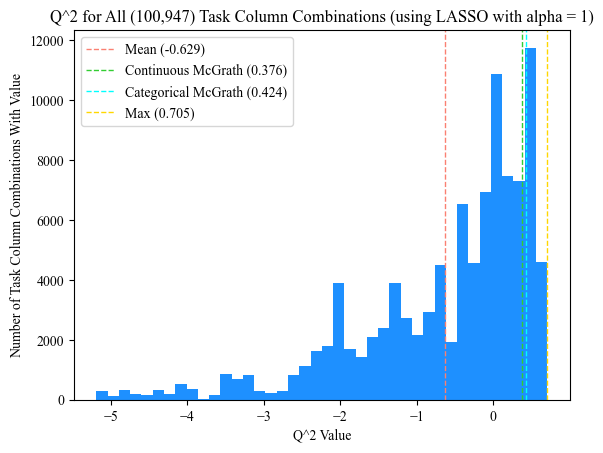

In [157]:
# these are from the LASSO
plot_q2_combination_hist(q2_from_diff_task_cols_lasso, dv_output_dict_comparison_LASSO, col = "q2", dv = "score", title_append = " (using LASSO with alpha = 1)")

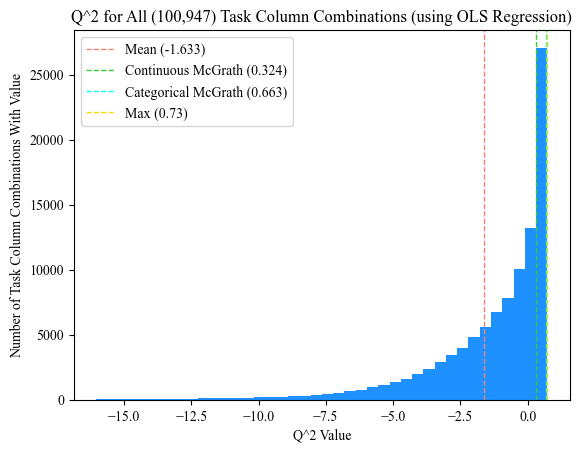

In [158]:
# these are from the OLS
plot_q2_combination_hist(q2_from_diff_task_cols_filtered, dv_output_dict_comparison, col = "q2", dv = "score", df_for_metrics = q2_from_diff_task_cols, title_append = " (using OLS Regression)")

In [159]:
comms_csvs_filtered = comms_csvs
for dv in COMMS_DVS:
   col = "q2_" + dv
   comms_csvs_filtered = comms_csvs_filtered[comms_csvs_filtered[col] > -10]

In [160]:
comms_csvs_filtered.describe()

,q2_turn_taking_index,q2_gini_coefficient_sum_num_messages,q2_sum_num_messages,q2_average_positive_bert,q2_team_burstiness
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.316726,-0.043505,-0.021782,-0.233343,-0.060528
std,0.978058,0.534123,0.436427,0.767136,0.280605
min,-9.959276,-9.854580,-9.241653,-9.962842,-8.405653
25%,-0.396880,-0.104118,-0.129460,-0.262689,-0.055672
50%,0.009908,0.119131,0.102259,0.010704,0.023539
75%,0.188570,0.242199,0.248559,0.132704,0.046472
max,0.265657,0.316249,0.331525,0.173022,0.056128


In [161]:
comm_dv_translation = {
    "turn_taking_index": "Turn Taking Index",
    "gini_coefficient_sum_num_messages": "Gini Coefficient",
    "sum_num_messages": "Total Number of Messages",
    "average_positive_bert": "Average Positive BERT",
    "team_burstiness": "Team Burstiness"
}

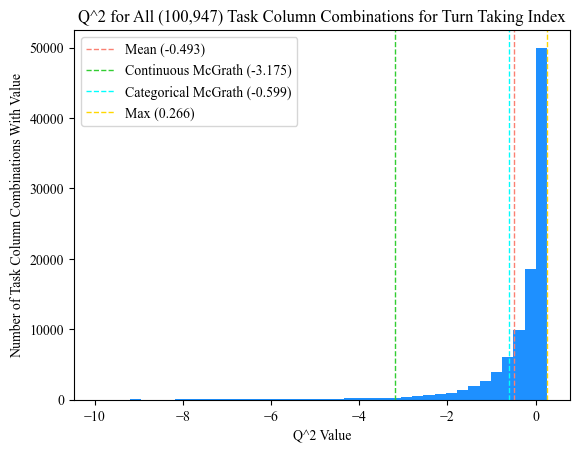

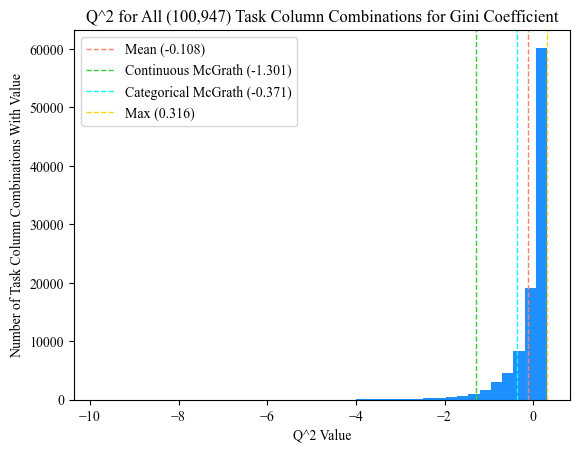

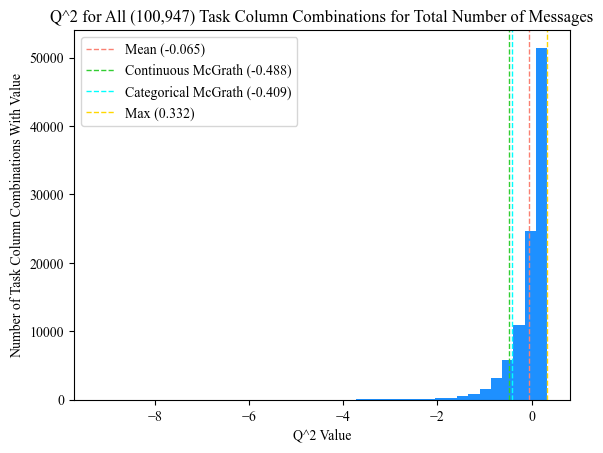

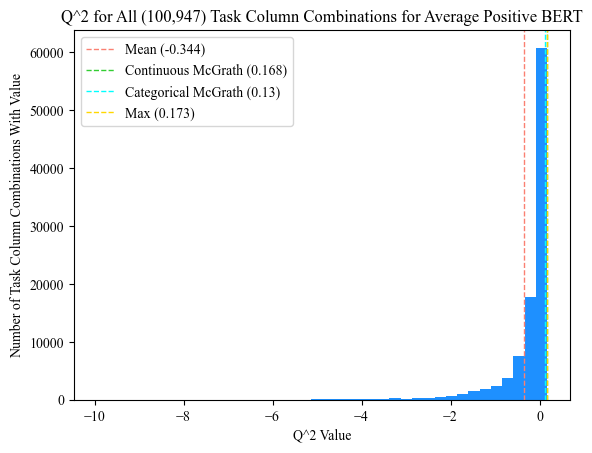

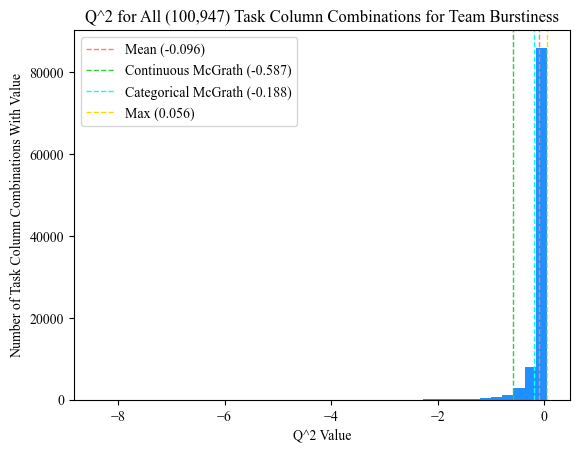

In [162]:
# plot a histogram of the q2 values for all five dependent variables
for dv in COMMS_DVS:
    col = "q2_" + dv
    plot_q2_combination_hist(comms_csvs_filtered, dv_output_dict_comparison_comms, col = col, dv = dv, df_for_metrics = comms_csvs, title_append=" for " + comm_dv_translation[dv])

Explore what the selected task columns are

In [163]:
mcgrath_colnames

['Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Type 3 and Type 4 (Objective Correctness)']

In [164]:
# Print the row associated with the max (OLS)
maxq2_cols = q2_from_diff_task_cols.iloc[q2_from_diff_task_cols["q2"].idxmax()]
maxq2_cols["selected_task_cols"]

"('Type 7 (Battle)', 'Type 8 (Performance)', 'Solution Scheme Multiplicity', 'Shared Knowledge', 'Type 3 and Type 4 (Objective Correctness)', 'Creativity Input')"

In [ ]:
# Print the row associated with the max (LASSO)
maxq2_cols_lasso = q2_from_diff_task_cols_lasso.iloc[q2_from_diff_task_cols_lasso["q2"].idxmax()]
maxq2_cols_lasso["selected_task_cols"]

In [ ]:
get_q2(team_multi_task_data[["score", "task_name"]],
    team_multi_task_data[list(ast.literal_eval(maxq2_cols["selected_task_cols"])) + ["playerCount", "Low", "Medium", "task_name"]],
    estimator = LinearRegression()
)

In [ ]:
# what's the worst performing one?
minq2_cols = q2_from_diff_task_cols.iloc[q2_from_diff_task_cols["q2"].idxmin()]
minq2_cols["selected_task_cols"]

In [ ]:
get_q2(team_multi_task_data[["score", "task_name"]],
    team_multi_task_data[list(ast.literal_eval(minq2_cols["selected_task_cols"])) + ["playerCount", "Low", "Medium", "task_name"]],
    estimator = LinearRegression()
)

In [ ]:
get_q2(team_multi_task_data[["score", "task_name"]],
    team_multi_task_data[list(ast.literal_eval(maxq2_cols["selected_task_cols"])) + ["playerCount", "Low", "Medium", "task_name"]],
    estimator = LinearRegression()
)

In [ ]:
get_q2(team_multi_task_data[["score", "task_name"]],
    team_multi_task_data[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]],
    estimator = LinearRegression()
)

# Trying Fancier Models with Hyperparameter Optimization (HPO)

In [ ]:
# code adapted from Mohammed's q2 optimization notebook
model_dict = {
            # "RandomForestRegressor":{"model":RandomForestRegressor,
            #     "params":[{"name":"n_estimators", "type":"range", "bounds":[2,200]},
            #             {"name":"max_depth", "type":"range", "bounds":[1,5]},
            #             {"name":"min_samples_leaf", "type":"range", "bounds":[1,5]}]},
            # "ElasticNet":{ "model": ElasticNet,
            #     "params":[{"name": "alpha", "type": "range", "bounds":[0.001,1.0]},
            #             {"name": "l1_ratio", "type": "range", "bounds":[0.0,1.0]},
            #             {"name": "max_iter", "type": "range", "bounds":[200, 2000]},
            #             {"name": "selection", "type": "choice", "values":["cyclic", "random"]}
            #         ]},
            # "Lasso": { "model": Lasso,
            #     "params":[{"name": "alpha", "type": "range", "bounds":[0.000000001,1.0]},
            #             {"name": "max_iter", "type": "range", "bounds":[100000, 300000]}]   
            # },
            "MLPRegressor":{"model": MLPRegressor,
            "params":[
                    {"name":"activation", "type":"choice", "values":["identity", "logistic", "tanh", "relu"]},
                    {"name":"solver", "type":"choice", "values":["sgd", "adam"]},
                    {"name": "alpha", "type": "range", "bounds":[0.0001,1.0]},
                    {"name":"learning_rate", "type":"choice", "values":["constant", "adaptive"]},
                    {"name":"learning_rate_init", "type":"range", "bounds":[0.0001, 0.01]},
                    {"name":"max_iter", "type":"range", "bounds":[350, 650]}
                ]}
			}

In [ ]:
def get_optimal_model(y, X, model_type, total_trials):

    best_parameters, best_values, experiment, model = optimize(
        parameters= model_dict[model_type]["params"],
        evaluation_function=lambda p: get_q2(y, X, model_dict[model_type]["model"](**p)),
        minimize=False,
        total_trials=total_trials,
    )
    optimal_parameters = best_parameters 
    optimization_q2 = best_values[0]["objective"]

    return(optimal_parameters, optimization_q2)

In [ ]:
optimal_dict = {
    "dv": [],
    "optimal_q2": [],
    "optimal_params": [],
    "model_type": []
}

In [ ]:
dvs = ["score"]

for model_type in model_dict.keys():
    for dv in dvs:
        # set up x and y
        y_dv = team_multi_task_data[[dv, "task_name"]]
        x_tasks = team_multi_task_data[list(task_cols_to_use) + ["task_name"]]
        # x_tasks = team_multi_task_data[all_features_and_interactions + ["task_name"]]

        optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 30)
        optimal_dict["dv"].append(dv)
        optimal_dict["optimal_q2"].append(optimal_q2)
        optimal_dict["optimal_params"].append(optimal_params)
        optimal_dict["model_type"].append(model_type)

        # save the optimal_dict in the future
        with open('./task_map_explorations_with_multitask/optimal_dict_MLP_with_task_features_30_trials_052524.pkl', 'wb') as pkl_file:
            pickle.dump(optimal_dict, pkl_file)

In [ ]:
pd.DataFrame(optimal_dict)

In [ ]:
index_of_max_q2 = optimal_dict['optimal_q2'].index(max(optimal_dict['optimal_q2']))

# MLPRegressor
best_estimator = MLPRegressor(
    alpha = optimal_dict["optimal_params"][index_of_max_q2]["alpha"],
    learning_rate_init = optimal_dict["optimal_params"][index_of_max_q2]["learning_rate_init"],
    max_iter = optimal_dict["optimal_params"][index_of_max_q2]["max_iter"],
    activation = optimal_dict["optimal_params"][index_of_max_q2]["activation"],
    solver = optimal_dict["optimal_params"][index_of_max_q2]["solver"],
    learning_rate = optimal_dict["optimal_params"][index_of_max_q2]["learning_rate"]
)

### Re-run McGrath Comparison with Optimized MLPRegressor

In [ ]:
def get_mcgrath_output(estimator):
    
    comparison_dict = {}
    for dv in ["score"]:
        comparison_dict[dv] = {}
        comparison_dict[dv]["mcgrath_continuous"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]], estimator = estimator)
        comparison_dict[dv]["mcgrath_categorical"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]], estimator = estimator)
        comparison_dict[dv]["lasso_selected_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(nonzero_lasso_weights_task) + ["playerCount", "Low", "Medium", "task_name"]], estimator = estimator)
        comparison_dict[dv]["all_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]], estimator = estimator)
    return(comparison_dict)

In [ ]:
get_mcgrath_output(best_estimator)

In [ ]:
# lasso example
best_lasso_estimator = Lasso(
        alpha = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("Lasso")]["alpha"],
        max_iter = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("Lasso")]["max_iter"],
    )
get_mcgrath_output(best_lasso_estimator)

In [ ]:
# RF example
best_RF_estimator = RandomForestRegressor(
    n_estimators = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("RandomForestRegressor")]["n_estimators"],
    max_depth = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("RandomForestRegressor")]["max_depth"],
    min_samples_leaf = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("RandomForestRegressor")]["min_samples_leaf"]
)
get_mcgrath_output(best_RF_estimator)

In [ ]:
# elasticNet example
best_elasticNet_estimator = ElasticNet(
    alpha = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["alpha"],
    l1_ratio = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["l1_ratio"],
    max_iter = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["max_iter"],
    selection = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["selection"]
)
get_mcgrath_output(best_elasticNet_estimator)

## Train on 9 tasks, Test on 1 task: Predicting DV's Based on Task Attributes

## Q^2 by Number of Features

In [ ]:
# q^2 for univariate features
q_2_for_all_dvs_task = []
dvs = ["score"]    
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
        y_dv = team_multi_task_data[[dv, "task_name"]]
        x_tasks = team_multi_task_data[[col] + ["task_name"]]
        q2 = get_q2(y_dv, x_tasks)

        within_dv_arr.append(q2)

    q_2_for_all_dvs_task.append(within_dv_arr)

In [ ]:
# turn this into a dataframe
q2_by_dv_df_task = pd.DataFrame(q_2_for_all_dvs_task, columns=task_cols_to_use, index = dvs)
# sort by average
q2_by_dv_df_task = q2_by_dv_df_task.reindex(q2_by_dv_df_task.mean().sort_values(ascending=False).index, axis=1)

In [ ]:
q2_by_dv_df_task

In [ ]:
# get top univariate features
def top_n_q2_for_index(index, n):
    q2_by_dv_df = q2_by_dv_df_task
    top_columns = q2_by_dv_df.loc[index].nlargest(n).index.tolist()
    return top_columns

In [ ]:
def get_q2_improvement_with_number_of_tasks(estimator, feature_list, dvs = ["score"], optimize_each_step = False, model_type = None):   
    dv_output_dict_best = {}

    for i, dv in enumerate(dvs):
        dv_output_dict_best[dv] = []

        for num_features in range(1, len(feature_list)+1):
            print("Now running models for " + str(num_features) + " features...")
            
            # select the best model by choosing the top features in terms of univariate q^2
            top_features_class = top_n_q2_for_index(dv, num_features)
            y_dv = team_multi_task_data[[dv, "task_name"]]
            x_tasks = team_multi_task_data[top_features_class + ["task_name"]]

            if(optimize_each_step): # optimize a model with hyperparameters for THIS set of features
                optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 10)
                print("Found optimal model with Q^2 of " + str(optimal_q2))
                estimator = model_dict[model_type]["model"](**optimal_params)
            
            q2_class = get_q2(y_dv, x_tasks, estimator=estimator) 
            dv_output_dict_best[dv].append(q2_class)
    
    return dv_output_dict_best

In [ ]:
for dv in ["score"]:#, "duration", "efficiency"]:

    # best_estimator = ElasticNet(
    #     alpha = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["alpha"],
    #     l1_ratio = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["l1_ratio"],
    #     max_iter = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["max_iter"],
    #     selection = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["selection"]
    # )

    dv_output_dict_best = get_q2_improvement_with_number_of_tasks(estimator = best_lasso_estimator, feature_list = task_cols_to_use)

### Line Plot as Number of Features Increases

In [ ]:
def plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list, title):
    fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

    # Store colors for each DV
    dv_colors = {}

    width = 0.16  # the width of the bars
    multiplier = 0

    for dv in df_q2_means_for_feature.columns:
        means_for_key = df_q2_means_for_feature[dv]
        # stds_for_key = df_q2_stds_for_feature[dv]
        # offset = width * multiplier
        # offset_back = (0.16) * 2.5
        # line plot version
        line, = ax.plot(np.arange(1, len(feature_list)+1), means_for_key, label=f'{dv}')
        dv_colors[dv] = line.get_color()  # Store the color for this DV

        # bar plot version
        # rects = ax.bar(np.arange(1, len(feature_list)+1) + offset - offset_back, means_for_key, width, label=f'{dv}')
        for i in range(1, len(feature_list)+1):
            x = i # + offset - offset_back
            y = means_for_key[i-1]
            # std = stds_for_key[i-1]
            # ax.errorbar(x, y, std, color="black")
        multiplier += 1

    # Adding horizontal gray line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Add horizontal lines for "optimal" model performance for each DV
    # TODO --- this needs to be adjusted based on the optimality of task class LOO versus task instance LOO
    # for dv in df_q2_means_for_feature.columns:
    #     optimal_df = pd.DataFrame(optimal_dict)
    #     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
    #     best_perf = np.max(performance_for_dv["optimal_q2"])
    #     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

    # ax.set_ylim(-4, 4)
    ax.legend(fontsize=14, loc='lower right')
    plt.xticks(ticks=[_ for _ in range(1, len(feature_list)+1)], fontsize=24)
    plt.yticks(fontsize=24)

    plt.xlabel('Number of Task Features Included', fontsize=24)
    plt.ylabel('Q^2', fontsize=24)

    plt.title(title, fontsize = 24)

In [ ]:
df_q2_means_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_means_for_feature[key] = means

plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list = task_cols_to_use, title = 'Q^2 of Model (LASSO) Based on Number of Task Features Included; LOO by TASK CLASS')

In [ ]:
tasks_unique = team_multi_task_data["task_name"].unique()

In [ ]:
dvs = ["score"]
q2_by_task_output_dict = {}

for dv in dvs:
    q2_by_task_output_dict[dv] = {}

    for num_tasks in range(1, len(tasks_unique)):
        print("Now running models for " + str(num_tasks) + " tasks...")
        q2_by_task_output_dict[dv][str(num_tasks)] = []

        ### For holding out a FULL TASK
        y_dv = team_multi_task_data[[dv, "task_name"]]
        # x_tasks = team_multi_task_data[all_features_and_interactions + ["task_name"]] # all task features and interactions
        x_tasks = team_multi_task_data[list(task_cols_to_use) + ["task_name"]] # only task features
        q2 = get_q2(y_dv, x_tasks, num_task_holdouts=len(tasks_unique)-num_tasks, estimator = best_lasso_estimator)
        q2_by_task_output_dict[dv][str(num_tasks)].append(q2)

In [ ]:
df_q2_means_for_task = pd.DataFrame()
for key in q2_by_task_output_dict.keys():
    means = [np.mean(sublist) for sublist in q2_by_task_output_dict[key].values()]
    df_q2_means_for_task[key] = means
df_q2_means_for_task

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

width = 0.16  # the width of the bars
multiplier = 0

dv_colors = {}

for dv in df_q2_means_for_task.columns:
    means_for_key = df_q2_means_for_task[dv]
    # stds_for_key = df_q2_stds_for_task[dv]
    # line plot version
    line, = ax.plot(np.arange(1, len(tasks_unique)), means_for_key, label=f'{dv}')
    dv_colors[dv] = line.get_color()  # Store the color for this DV
    # bar plot version
    # rects = ax.bar(np.arange(1, len(tasks_unique)) + offset - offset_back, means_for_key, width, label=f'{dv}')
    # for i in range(1, len(tasks_unique)):
    #     x = i
    #     y = means_for_key[i-1]
    #     # std = stds_for_key[i-1]
    #     ax.errorbar(x, y, std, color="black")
    # multiplier += 1

ax.legend(fontsize=14, loc='lower right')
plt.xticks(ticks=[_ for _ in range(1, len(tasks_unique))], fontsize=24)
plt.xlabel('Number of Tasks Trained On', fontsize=24)

# yticks = np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 0.1, 0.1)
# yticks = np.unique(np.concatenate((yticks, np.round(yticks))))
# yticklabels = [f'{round(tick, 1)}' if round(tick, 1) == tick else '' for tick in yticks]
# plt.yticks(yticks, yticklabels, fontsize=24)

# Adding horizontal gray line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

# Adding lines for optimal performance
# TODO --- this needs to be redone based on the task class holdout scheme
# for dv in df_q2_means_for_feature.columns:
#     optimal_df = pd.DataFrame(optimal_dict)
#     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
#     best_perf = np.max(performance_for_dv["optimal_q2"])
#     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

plt.ylabel('Q^2', fontsize=24)

plt.title('Q^2 by Number of Tasks In Training Set -- Using Optimized LASSO (On Task Features ONLY) to Predict on Held Out Task(s)', fontsize=24)

# [Backlog] Q^2 at the Instance Level

In [ ]:
# This does q2 at the *task instance level*
def q2_baseline_models(y, X, estimator):
    baseline_models = []
    for loo_index in range(len(y)):
        if hasattr(estimator, "random_state"):
            estimator.random_state = loo_index

        x_train, y_train = reshape_x_y(X.drop(loo_index), y.drop(loo_index))
        baseline_models.append(deepcopy(estimator.fit(X=x_train, y=y_train.ravel())))
        
    return baseline_models

def get_q2_task_instance(y, X, estimator=LinearRegression()):
    models = q2_baseline_models(y, X, estimator)
    q2_means = []
    q2_preds = []
    
    for loo_index in range(len(y)):
        q2_means.append(y.drop(loo_index).mean())
        q2_preds.append(models[loo_index].predict(np.array(X.iloc[loo_index]).reshape(1,-1)))

    # fix dimensions
    q2_means = np.array(q2_means)
    q2_preds = np.array(q2_preds).flatten()

    q2 = 1 - np.sum((q2_preds - np.array(y).flatten())**2) / np.sum((q2_means - np.array(y).flatten())**2)
    
    return q2